## TODO

- Add disordered regions
- Are there N/C terminal regexes that are not matching correctly?
- Do I require each isoform has at least one PPI?
- vizualize motifs

In [101]:
from data_loading import load_y2h_isoform_data

y2h = load_y2h_isoform_data()

In [104]:
print(y2h['ad_clone_acc'].nunique(),
      y2h['ad_gene_symbol'].nunique(),
      y2h['db_gene_symbol'].nunique(),
      y2h[['ad_gene_symbol', 'db_gene_symbol']].drop_duplicates().shape[0])

170 64 508 936


In [1]:
import re

import numpy as np
import pandas as pd
import seaborn as sns

from data_loading import (load_full_y2h_data_including_controls,
                          load_valid_isoform_clones,
                          load_annotated_TFiso1_collection,
                          load_human_tf_db,
                          load_tf_families,
                          load_pfam_domains_horfeome)


pd.set_option('display.max_columns', 100)
pd.set_option('display.max_colwidth', 255)

In [2]:
# looking at Lambert et al. binding mode data, to see if it can help
tfdb = load_human_tf_db()
print(tfdb['Binding mode'].value_counts())
print()
print(tfdb.loc[tfdb['Binding mode'] == 'Obligate heteromer', 'DBD'].value_counts())


Monomer or homomultimer                1564
Obligate heteromer                       49
Low specificity DNA-binding protein      26
Name: Binding mode, dtype: int64

bHLH                25
Unknown              7
bZIP                 6
E2F                  3
Nuclear receptor     2
SMAD                 2
CBF/NF-Y             1
DM                   1
Rel                  1
TBP                  1
Name: DBD, dtype: int64


In [3]:
def load_3did_DDIs():
    fpath = '../data/external/3did_flat_2022-05.txt'
    domain_pairs = []
    for line in open(fpath, 'r'):
        if line.startswith('#=ID'):
            domain_pairs.append((line.split()[3][1:8], line.split()[4][:7]))
    df = pd.DataFrame(data=domain_pairs, columns=['pfam_a', 'pfam_b'])
    if df.duplicated().any():
        raise UserWarning('unexpected duplicates')
    return df


def load_cofactors():
    cof = pd.read_csv('../data/external/AnimalTFDB3_Homo_sapiens_TF_cofactors.txt',
                    sep='\t')
    if cof['Symbol'].duplicated().any():
        raise UserWarning('unexpected duplicates')
    return cof

In [4]:
tfs = load_annotated_TFiso1_collection()
ppi = load_full_y2h_data_including_controls()
ppi = ppi.loc[ppi['category'] == 'tf_isoform_ppis', :]
ppi['gene_level_pair'] = ppi['ad_gene_symbol'] + '_' + ppi['db_gene_symbol']
ppi['ad_iso_id'] = ppi['ad_clone_acc'].apply(lambda x: x.split('|')[0] + '-' + x.split('|')[1].split('/')[0])
# dropping gene with insertion relative to reference geneome
ppi = ppi.loc[~(ppi['ad_gene_symbol'] == 'PCGF6'), :]
iso = load_valid_isoform_clones()
iso = iso.set_index('clone_acc')

# TODO: add in pfam AC for ZF for ZF array
tf_pfam_domains = {tf.name: {dom.accession for iso in tf.cloned_isoforms
                             for dom in iso.aa_seq_features 
                             if dom.category == 'Pfam_domain'}
                   for tf in tfs.values()}
pfam = load_pfam_domains_horfeome()

# kaia added this line as types weren't auto-converting in pandas version whatever
pfam['orf_id'] = pfam['orf_id'].astype(int)

partner_domains = pfam.groupby('orf_id')['pfam_accession'].apply(set)
ppi['partner_domains'] = ppi['db_orf_id'].map(partner_domains)
ppi['tf_domains'] = ppi['ad_gene_symbol'].map(tf_pfam_domains)

# check no-overlap with domain motif
ddi = load_3did_DDIs()

def matching_DDIs(row):
    if (
        pd.isnull(row['partner_domains']) or
        pd.isnull(row['tf_domains'])
        ):
        return np.nan
    if (
        len(row['partner_domains']) == 0 or
        len(row['tf_domains']) == 0
    ):
        return np.nan
    matches = ddi.loc[(ddi['pfam_a'].isin(row['partner_domains']) &
                    ddi['pfam_b'].isin(row['tf_domains'])) |
                   (ddi['pfam_a'].isin(row['tf_domains']) &
                    ddi['pfam_b'].isin(row['partner_domains']))].values
    if len(matches) == 0:
        return np.nan
    return frozenset((a, b) for a, b in matches)

ppi['matching_DDI'] = ppi.apply(matching_DDIs, axis=1)

ggi = ppi.loc[:, ['ad_gene_symbol', 'db_gene_symbol', 'db_orf_id', 'matching_DDI']].drop_duplicates()

df = pd.DataFrame(data={tuple(sorted(p)) for ps in ggi.loc[ggi['matching_DDI'].notnull(), 'matching_DDI'].unique() for p in ps},
                  columns=['pfam_a', 'pfam_b'])
df['name_a'] = df['pfam_a'].map(pfam.loc[:, ['pfam_accession', 'domain_name']]
                                    .drop_duplicates()
                                    .set_index('pfam_accession')['domain_name'])
df['name_b'] = df['pfam_b'].map(pfam.loc[:, ['pfam_accession', 'domain_name']]
                                    .drop_duplicates()
                                    .set_index('pfam_accession')['domain_name'])
df['description_a'] = df['pfam_a'].map(pfam.loc[:, ['pfam_accession', 'domain_description']]
                                    .drop_duplicates()
                                    .set_index('pfam_accession')['domain_description'])
df['description_b'] = df['pfam_b'].map(pfam.loc[:, ['pfam_accession', 'domain_description']]
                                    .drop_duplicates()
                                    .set_index('pfam_accession')['domain_description'])
df.sort_values(['name_a', 'name_b']).to_csv('../data/internal/DDI_for_manual_annotation.tsv', index=False, sep='\t')

# filter and consolidate DDIs

ddi_annot = pd.read_csv('../data/internal/DDI_manual_annotation.tsv', sep='\t')

valid_ddi_pairs = {frozenset(p) for p in ddi_annot.loc[ddi_annot['to_use'], ['pfam_a', 'pfam_b']].values}
def filter_ddi(pairs):
    if pd.isnull(pairs):
        return np.nan
    passed = frozenset(p for p in pairs if frozenset(p) in valid_ddi_pairs)
    if len(passed) == 0:
        return np.nan
    return passed

ggi['matching_DDI_filtered'] = ggi['matching_DDI'].apply(filter_ddi)

ddi_to_merge = {
    ('PF00170', 'PF07716'): ('PF00170', 'PF00170'),  # bZIP-bZIP
    ('PF00170', 'PF03131'): ('PF00170', 'PF00170'),  # bZIP-bZIP
    ('PF07716', 'PF07716'): ('PF00170', 'PF00170'),  # bZIP-bZIP
    ('PF03131', 'PF03131'): ('PF00170', 'PF00170'),  # bZIP-bZIP
    ('PF00046', 'PF05920'): ('PF00046',	'PF00046'),  # homeobox-homeobox
    ('PF05920', 'PF05920'): ('PF00046',	'PF00046'),  # homeobox-homeobox
    ('PF00989', 'PF14598'): ('PF00989', 'PF00989'),  # PAS-PAS
    ('PF00989', 'PF08447'): ('PF00989', 'PF00989'),  # PAS-PAS
    ('PF00989', 'PF13426'): ('PF00989', 'PF00989'),  # PAS-PAS
    ('PF14598', 'PF14598'): ('PF00989', 'PF00989'),  # PAS-PAS
    ('PF08447', 'PF14598'): ('PF00989', 'PF00989'),  # PAS-PAS
    ('PF08447', 'PF08447'): ('PF00989', 'PF00989'),  # PAS-PAS
}
ggi['matching_DDI_filtered'] = ggi['matching_DDI_filtered'].apply(lambda x: frozenset(ddi_to_merge.get(tuple(sorted(p)), tuple(sorted(p))) for p in x) if pd.notnull(x) else x)

pfam_name = (pfam.loc[:, ['pfam_accession', 'domain_name']]
                 .drop_duplicates()
                 .set_index('pfam_accession')
                 ['domain_name']
                 .to_dict())
pfam_name['PF17725'] = 'YBD'  # one missing from that table because it was added more recently
ggi['DDI'] = ggi['matching_DDI_filtered'].apply(lambda x: ' and '.join(pfam_name[a] + '|' + pfam_name[b] for a, b in x) if pd.notnull(x) else x)

tfdb = load_human_tf_db()
ggi['is_tf_tf'] = ggi['db_gene_symbol'].isin(tfdb['HGNC symbol'].values)
fam = load_tf_families()
ggi['is_same_family_tf'] = (ggi['ad_gene_symbol'].map(fam) == ggi['db_gene_symbol'].map(fam))

dlm = pd.read_csv('../data/external/elm_interaction_domains.tsv',
                  sep='\t')
elm = pd.read_csv('../data/external/elm_classes.tsv', header=0, comment='#', sep='\t')
orfs_with_slim_dom = pfam.loc[pfam['pfam_accession'].isin(dlm['Interaction Domain Id']),
                              'orf_id'].unique()
partner_slim_binding_doms = {orf_id: frozenset([d for d in pfam.loc[pfam['orf_id'] == orf_id, 'pfam_accession'].unique() 
                                                if d in dlm['Interaction Domain Id'].unique()]) 
                             for orf_id in orfs_with_slim_dom}
ggi['slim_binding_domains_in_partner'] = ggi['db_orf_id'].map(partner_slim_binding_doms)

reading from cache


In [5]:
print(len(orfs_with_slim_dom), pfam['orf_id'].nunique())
ggi['putative_DMI'] = ggi['db_orf_id'].isin(orfs_with_slim_dom)
print(ggi['putative_DMI'].sum(), ggi['putative_DMI'].mean(), (ggi['DDI'].isnull() & ggi['putative_DMI']).sum())

candidates = (ggi.loc[ggi['putative_DMI'], :]
                                       .groupby(['db_gene_symbol', 'slim_binding_domains_in_partner'])
                                       .size()
                                       .to_frame())
candidates['names'] = (ggi.loc[ggi['putative_DMI'], :]
                                       .groupby(['db_gene_symbol', 'slim_binding_domains_in_partner'])
                                       ['ad_gene_symbol']
                                       .apply(lambda x: ' '.join(sorted(x))))
                                       
print('top slim binding partners:', candidates.sort_values(0, ascending=False).head(25))

print('')

3056 16480
395 0.2851985559566787 329
top slim binding partners:                                                                0  \
db_gene_symbol slim_binding_domains_in_partner                     
PIN1           (PF00397)                                      13   
PRKAA2         (PF00069, PF07714)                             11   
IL16           (PF00595)                                      10   
LNX1           (PF00595)                                       9   
HOXC8          (PF00046)                                       9   
SDCBP          (PF00595)                                       9   
MAPK9          (PF00069, PF07714)                              9   
HOXB5          (PF00046)                                       8   
HOXA1          (PF00046)                                       7   
RXRG           (PF00104)                                       7   
RUNX1T1        (PF01753)                                       6   
DVL3           (PF00595)                           

In [6]:
ggi.loc[ggi['putative_DMI'] & ggi['DDI'].notnull(), 'DDI'].value_counts()

Homeobox|Homeobox                                          22
Hormone_recep|Hormone_recep                                21
Pkinase|zf-C2H2                                            10
Hormone_recep|NR_Repeat and Hormone_recep|Hormone_recep     5
Ank|RHD_dimer                                               3
Homeobox|Homeobox and Pou|Pou and Homeobox|Pou              2
fn3|SET and SPRY|SET                                        1
Homeobox|Homeobox and Homeobox|Pou                          1
LIM|Ank_2                                                   1
Name: DDI, dtype: int64

In [7]:
dlm.loc[dlm['Interaction Domain Id'].isin(['PF07531', 'PF01753', 'PF08788'])]

,ELM identifier,Interaction Domain Id,Interaction Domain Description,Interaction Domain Name
45,LIG_MYND_1,PF01753,zf-MYND,MYND finger
195,LIG_MYND_2,PF01753,zf-MYND,MYND finger
196,LIG_MYND_3,PF01753,zf-MYND,MYND finger


In [8]:
# TFs with slim binding domains
slim_binding_doms = set(dlm['Interaction Domain Id'].unique())
tfs_with_slim_binding_doms = {tf_gene_symbol: frozenset(d for d in doms if d in slim_binding_doms) for tf_gene_symbol, doms in tf_pfam_domains.items()
                              if any(d in slim_binding_doms for d in doms)}
print(len(tfs_with_slim_binding_doms), 'TFs in TFiso1.0 with SLiM binding domain(s)')
ggi['slim_binding_domains_in_tf'] = ggi['ad_gene_symbol'].map(tfs_with_slim_binding_doms)
print(ggi['slim_binding_domains_in_tf'].notnull().sum(), 'gene-level PPI where TF has slim bindig domain')

46 TFs in TFiso1.0 with SLiM binding domain(s)
245 gene-level PPI where TF has slim bindig domain


In [9]:
ggi['slim_binding_domains_in_tf'].value_counts()

(PF00046)    171
(PF00104)     63
(PF00017)      9
(PF09270)      2
Name: slim_binding_domains_in_tf, dtype: int64

In [10]:
# STAT3 has SH2 domain -- but conserved in all isoforms
# RBPJ has BTD domain -- but conserved in all isoforms

In [11]:
ggi.loc[ggi['slim_binding_domains_in_tf'] == frozenset(['PF00104']), 'ad_gene_symbol'].value_counts()

ESRRA    14
PPARG    11
ESRRG    11
NR4A1     4
RXRG      4
NR4A2     4
RARG      3
PPARD     3
HNF4A     3
RARB      2
NR1H3     2
NR2F2     2
Name: ad_gene_symbol, dtype: int64

In [12]:
ggi.loc[ggi['slim_binding_domains_in_tf'] == frozenset(['PF00104']), 'db_gene_symbol'].value_counts()

RXRG       7
RXRB       5
NR0B1      5
NRIP1      3
ESRRG      2
VAX1       2
NCOA1      2
PSMC5      2
DPF2       2
CDKN2D     2
CENPX      1
ESRRA      1
ZNF76      1
FUCA1      1
NR0B2      1
LCOR       1
MSGN1      1
ZNF417     1
RRP8       1
TSTD2      1
SDCBP      1
MED25      1
INO80      1
MAPK9      1
KCTD13     1
PGBD1      1
NR1H3      1
RARA       1
RARB       1
RARG       1
LONRF1     1
NR2C1      1
MPPED2     1
SPG21      1
UBXN7      1
ZSWIM3     1
FMNL2      1
PRKCA      1
SMARCD3    1
UBE3A      1
TNNI2      1
Name: db_gene_symbol, dtype: int64

In [13]:
ggi.loc[ggi['db_gene_symbol'] == 'NR0B1']

,ad_gene_symbol,db_gene_symbol,db_orf_id,matching_DDI,matching_DDI_filtered,DDI,is_tf_tf,is_same_family_tf,slim_binding_domains_in_partner,putative_DMI,slim_binding_domains_in_tf
2293,PPARD,NR0B1,7215,"((PF00104, PF14046), (PF00104, PF00104), (PF00104, PF00105))","((PF00104, PF14046), (PF00104, PF00104))",Hormone_recep|NR_Repeat and Hormone_recep|Hormone_recep,True,False,(PF00104),True,(PF00104)
2531,PPARG,NR0B1,7215,"((PF00104, PF14046), (PF00104, PF00104), (PF00104, PF00105))","((PF00104, PF14046), (PF00104, PF00104))",Hormone_recep|NR_Repeat and Hormone_recep|Hormone_recep,True,False,(PF00104),True,(PF00104)
3454,HNF4A,NR0B1,7215,"((PF00104, PF14046), (PF00104, PF00104), (PF00104, PF00105))","((PF00104, PF14046), (PF00104, PF00104))",Hormone_recep|NR_Repeat and Hormone_recep|Hormone_recep,True,False,(PF00104),True,(PF00104)
7933,ESRRG,NR0B1,7215,"((PF00104, PF14046), (PF00104, PF00104), (PF00104, PF00105))","((PF00104, PF14046), (PF00104, PF00104))",Hormone_recep|NR_Repeat and Hormone_recep|Hormone_recep,True,False,(PF00104),True,(PF00104)
8474,ESRRA,NR0B1,7215,"((PF00104, PF14046), (PF00104, PF00104), (PF00104, PF00105))","((PF00104, PF14046), (PF00104, PF00104))",Hormone_recep|NR_Repeat and Hormone_recep|Hormone_recep,True,False,(PF00104),True,(PF00104)


In [14]:
dlm.loc[dlm['Interaction Domain Id'] == 'PF09270']

,ELM identifier,Interaction Domain Id,Interaction Domain Description,Interaction Domain Name
259,LIG_CSL_BTD_1,PF09270,BTD,Beta-trefoil DNA-binding domain


In [15]:
n_ggi = ggi.shape[0]
n_ddi = ggi['matching_DDI'].notnull().sum()
print(n_ggi, 'gene-level PPIs')
print(f'{n_ddi} ({n_ddi/n_ggi:.0%}) mapped to DDIs')
ggi['matching_DDI'].value_counts()

1385 gene-level PPIs
280 (20%) mapped to DDIs


((PF02023, PF02023))                                                                                                                                                                    44
((PF00010, PF00010))                                                                                                                                                                    42
((PF00096, PF13894))                                                                                                                                                                    30
((PF00105, PF00105), (PF00104, PF00104), (PF00104, PF00105))                                                                                                                            20
((PF00069, PF00096))                                                                                                                                                                    10
((PF00096, PF13894), (PF00096, PF13465), (PF00096, PF00096))     

In [16]:
# check the DDIs that were removed
#ggi.loc[ggi['matching_DDI'].notnull() & ggi['matching_DDI_filtered'].isnull()]

In [17]:
n_ggi = ggi.shape[0]
n_ddi = ggi['matching_DDI_filtered'].notnull().sum()
print(f'{n_ddi} ({n_ddi/n_ggi:.0%}) mapped to DDIs, after filtering')

225 (16%) mapped to DDIs, after filtering


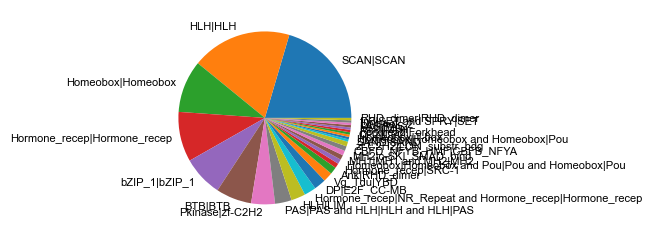

In [18]:
# names
from matplotlib import pyplot as plt
fig, ax = plt.subplots(1, 1)
ggi['DDI'].value_counts().plot.pie(ax=ax)
ax.set_ylabel('')
fig.savefig('../figures/DDI-types_pie.pdf',
            bbox_inches='tight')

In [19]:
(ggi['is_tf_tf'].mean(),
 ggi['is_same_family_tf'].mean(),
ggi.loc[ggi['DDI'].notnull(), 'is_tf_tf'].mean(),
ggi.loc[ggi['DDI'].notnull(), 'is_same_family_tf'].mean())

(0.3270758122743682, 0.17256317689530687, 0.8266666666666667, 0.76)

In [20]:
# domain removal
# for each alt iso, for each DDI, calc fraction of domain
# removed and fraction of PPIs retained
dom = pd.concat([g.aa_feature_disruption(g.cloned_reference_isoform.name) for g in tfs.values()])

In [21]:
df = ppi.loc[ppi['matching_DDI'].notnull(), :].copy()
ref_isos = {tf.cloned_reference_isoform.clone_acc for tf in tfs.values()}
positive_in_ref = df.loc[df['ad_clone_acc'].isin(ref_isos) & 
                         (df['Y2H_result'] == True), 'gene_level_pair'].unique()
df = df.loc[df['gene_level_pair'].isin(positive_in_ref) &
            ~df['ad_clone_acc'].isin(ref_isos), :]
df['matching_DDI'] = df['matching_DDI'].apply(filter_ddi)
df['matching_DDI'] = df['matching_DDI'].apply(lambda x: frozenset(ddi_to_merge.get(tuple(sorted(p)), tuple(sorted(p))) for p in x) if pd.notnull(x) else x)
df = df.loc[df['matching_DDI'].notnull(), :]

merged_domains = {'PF07716': 'PF00170',  # bZIP
 'PF03131': 'PF00170',  # bZIP
 'PF05920': 'PF00046',  # homeobox
'PF14598': 'PF00989',  # PAS
'PF08447': 'PF00989',  # PAS
'PF13426': 'PF00989',  # PAS
}
df['tf_domains'] = df['tf_domains'].apply(lambda x: {merged_domains.get(d, d) for d in x})
dom['accession'] = dom['accession'].apply(lambda x: merged_domains.get(x, x))


def pick_the_one_domain(row):
    ddi_domains = {x for a, b in row['matching_DDI'] for x in [a, b]}
    ds = {d for d in row['tf_domains'] if d in ddi_domains}
    if len(ds) == 0:
        print(row)
        raise UserWarning('something wrong')
    return ds

df['tf_domains'] = df.apply(pick_the_one_domain, axis=1)

def filter_for_domain_in_cloned_reference_isoform(row):
    in_ref = {d.accession for d in tfs[row['ad_gene_symbol']].cloned_reference_isoform.aa_seq_features}
    return {d for d in row['tf_domains'] if d in in_ref}


df['tf_domains'] = df.apply(filter_for_domain_in_cloned_reference_isoform, axis=1)
df = df.loc[df['tf_domains'].map(lambda x: len(x) > 0), :]

def fraction_of_DDI_domains_removed(row):
    ds = dom.loc[(dom['alt_iso'] == row['ad_iso_id']) 
                  & dom['accession'].isin(row['tf_domains']), :]
    if ds.shape[0] == 0:
        print(row)
        raise UserWarning('something wrong')
    return ds[['deletion', 'frameshift']].sum().sum() / ds['length'].sum()

def insertion_in_DDI_domains(row):
    ds = dom.loc[(dom['alt_iso'] == row['ad_iso_id']) 
                  & dom['accession'].isin(row['tf_domains']), :]
    return ds['insertion'].sum()

df['fraction_of_DDI_domains_removed'] = df.apply(fraction_of_DDI_domains_removed, axis=1)
df['insertion_in_DDI_domains'] = df.apply(insertion_in_DDI_domains, axis=1)

df['tf_domains'] = df['tf_domains'].apply(frozenset)

In [22]:
data = (df.loc[df['Y2H_result'].notnull(), :]
          .groupby(['ad_iso_id', 'tf_domains'])
          ['fraction_of_DDI_domains_removed']
          .mean()
          .to_frame())

# kaia added these lines bc type conversion wasn't working in my version of pandas
nonan = df.loc[df['Y2H_result'].notnull(), :]
nonan['Y2H_result'] = nonan['Y2H_result'].astype(int)

data['Y2H_result_mean'] = nonan.groupby(['ad_iso_id', 'tf_domains'])['Y2H_result'].mean()
data['insertion_in_DDI_domains'] = nonan.groupby(['ad_iso_id', 'tf_domains'])['insertion_in_DDI_domains'].mean()


/var/folders/4f/st3pbvs10sd68jl3b4p861h80000gn/T/ipykernel_72223/1488141778.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nonan['Y2H_result'] = nonan['Y2H_result'].astype(int)


In [23]:
data.loc[data['insertion_in_DDI_domains'] > 0]

,,fraction_of_DDI_domains_removed,Y2H_result_mean,insertion_in_DDI_domains
ad_iso_id,tf_domains,,,
ARNTL2-1,(PF00010),0.000000,1.0,34.0
ARNTL2-3,(PF00010),0.000000,1.0,34.0
PPARD-2,(PF00104),0.336898,0.0,2.0
PPARD-3,(PF00104),0.336898,0.0,2.0
SMAD4-1,"(PF03165, PF03166)",0.153846,1.0,4.0


In [24]:
data.reset_index()[data.reset_index()['ad_iso_id'].duplicated(keep=False)]

,ad_iso_id,tf_domains,fraction_of_DDI_domains_removed,Y2H_result_mean,insertion_in_DDI_domains
69,ZBTB25-2,(PF00096),0.500000,0.0,0.0
70,ZBTB25-2,(PF00651),0.580952,0.0,0.0
71,ZBTB25-4,(PF00096),1.000000,0.0,0.0
72,ZBTB25-4,(PF00651),0.580952,0.0,0.0


In [25]:
# add distance from domain
# TODO move to isolib
def n_aa_change_from_feature(gene, ref_iso_name, alt_iso_name, domain_start, domain_end):
    algn = gene.pairwise_changes_relative_to_reference(ref_iso_name, alt_iso_name)

    def _coords_transform_aa_seq_to_alignment(i, alignment):
        if i > len(alignment.replace("I", "")):
            raise ValueError("position is not in isoform AA sequence")
        aa_seq_indices = [
            "" if c == "I" else len(alignment[:j].replace("I", ""))
            for j, c in enumerate(alignment)
        ]
        return aa_seq_indices.index(i)
    
    start = _coords_transform_aa_seq_to_alignment(domain_start, algn)
    end = _coords_transform_aa_seq_to_alignment(domain_end - 1, algn) + 1

    if not all(x == 'M' for x in algn[start:end]):
        return 0  # change is within the domain
    
    big_number = 9999999999999999999999999
    c_dist = big_number
    n_dist = big_number
    for i, l in enumerate(reversed(algn[:start])):
        if l != 'M':
            c_dist = i + 1
            break
    for i, l in enumerate(algn[end:]):
        if l != 'M':
            n_dist = i + 1
            break
    if c_dist == big_number and n_dist == big_number:
        raise UserWarning('problem calculating distance')
    return min([c_dist, n_dist])


def n_aa_to_all_features(self, ref_iso_name):
    results = []
    ref_iso = self._iso_dict[ref_iso_name]
    row = {"gene": self.name, "ref_iso": ref_iso_name}
    for aa_feature in ref_iso.aa_seq_features:
        for alt_iso_name, alt_iso in self._iso_dict.items():
            if alt_iso_name == ref_iso_name:
                continue
            row.update(
                {
                    "alt_iso": alt_iso_name,
                    "accession": aa_feature.accession,
                    "category": aa_feature.category,
                    "start_in_ref_iso": aa_feature.start,
                    "end_in_ref_iso": aa_feature.end,
                    "length": aa_feature.end - aa_feature.start,
                }
            )
            row.update({"n_aa_change_to_domain": n_aa_change_from_feature(self, ref_iso_name, alt_iso_name, aa_feature.start, aa_feature.end)})
            results.append(row.copy())
    results = pd.DataFrame(results)
    return results

dist = pd.concat([n_aa_to_all_features(g, g.cloned_reference_isoform.name) for g in tfs.values()])

def get_dist(row):
    alt_iso, dom_accessions = row.name
    return dist.loc[(dist['alt_iso'] == alt_iso) & (dist['accession'].isin(dom_accessions)),
                    'n_aa_change_to_domain'].min()

data['domain_n_aa_to_change'] = data.apply(get_dist, axis=1)

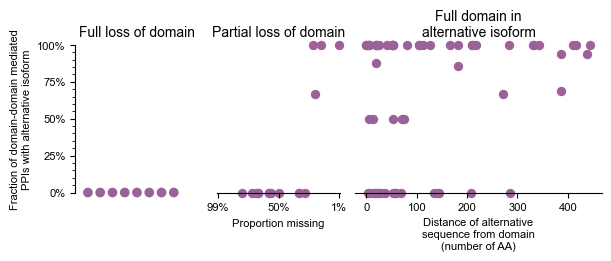

In [26]:
from matplotlib import pyplot as plt
COLOR_PURPLE = (155 / 255, 97 / 255, 153 / 255)


gs_kw = dict(width_ratios=[1, 1, 2])

fig, axs = plt.subplots(1, 3, sharey=True, gridspec_kw=gs_kw)
fig.set_size_inches(w=6, h=2.5)

point_size = 7

axs[0].set_title('Full loss of domain',
fontsize=10)
sns.swarmplot(data=data.loc[data['fraction_of_DDI_domains_removed'] == 1, :],
              y='Y2H_result_mean', 
              x='fraction_of_DDI_domains_removed',
              size=point_size,
         #     order=[
         #            'Full loss\nof DBD',
         #            ],
            clip_on=False,
              ax=axs[0],
              color=COLOR_PURPLE,
              alpha=1)

axs[1].set_title('Partial loss of domain',
fontsize=10)
partial_loss = (data['fraction_of_DDI_domains_removed'] > 0) & (data['fraction_of_DDI_domains_removed'] < 1)
axs[1].scatter(data.loc[partial_loss, 'fraction_of_DDI_domains_removed'].values,
               data.loc[partial_loss, 'Y2H_result_mean'].values,
           alpha=1,
           s=point_size**2/1.5,  # I don't think there should be a divide by anything here....
            color=COLOR_PURPLE,
           clip_on=False)
axs[1].set_xlabel('Proportion missing')
axs[1].set_xlim(1, 0)
axs[1].set_xticks([0.99, 0.5, 0.01])
axs[1].set_xticklabels([f'{x:.0%}' for x in axs[1].get_xticks()])
#axs[1].set_xticks(range(10, 91, 10), minor=True)



axs[2].set_title('Full domain in\nalternative isoform', fontsize=10)
axs[2].scatter(data.loc[(data['fraction_of_DDI_domains_removed'] == 0), 'domain_n_aa_to_change'].values,
               data.loc[(data['fraction_of_DDI_domains_removed'] == 0), 'Y2H_result_mean'].values,
           alpha=1,
           s=point_size**2/1.5,  # I don't think there should be a divide by anything here....
            color=COLOR_PURPLE,
           clip_on=False)
axs[2].set_xlabel('Distance of alternative\nsequence from domain\n(number of AA)')

for ax in axs:
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_ylim(0, 1)
for ax in axs[1:]:
    ax.spines['left'].set_visible(False)
    ax.yaxis.set_tick_params(which='both', length=0)
for i in [0]:
    axs[i].set_xlabel('')
    axs[i].set_ylabel('')
    axs[i].spines['bottom'].set_visible(False)
    axs[i].xaxis.set_tick_params(length=0)
    axs[i].set_xticks([])
axs[0].set_yticks([0, 0.25, 0.5, 0.75, 1])
axs[0].set_yticks(np.linspace(0, 1, 21), minor=True)
axs[0].set_yticklabels(['{:.0%}'.format(y) for y in axs[0].get_yticks()])
axs[0].set_ylabel('Fraction of domain-domain mediated\nPPIs with alternative isoform')
fig.savefig('../figures/PPI_vs_domain_removal.pdf', bbox_inches='tight')

In [27]:
data.loc[(data['fraction_of_DDI_domains_removed'] > 0) & (data['Y2H_result_mean'] > 0)]

,,fraction_of_DDI_domains_removed,Y2H_result_mean,insertion_in_DDI_domains,domain_n_aa_to_change
ad_iso_id,tf_domains,,,,
E2F3-3,(PF16421),0.202128,0.666667,0.0,0
FOS-2,(PF00170),0.222222,1.000000,0.0,0
LHX9-2,(PF00412),0.008621,1.000000,0.0,0
SMAD4-1,"(PF03165, PF03166)",0.153846,1.000000,4.0,0


### Cases of partial domain removal without full loss of PPIs

- E2F3-3, coiled-coil marked box domain binds DP TFs, binds DP1, DP2, not DP3. All novel isoforms. 
- FOS-2. Retains all the bzip partners despite missing some of the domain. Maybe the basic region and might lose DNA binding (no data). 
- LHX9-2 loses one amino acid of LIM domain but doesn't lose any binding partners
- SMAD4-1. Loses some of MH2 domain. Doens't lose partners. Novel isoform.

/var/folders/4f/st3pbvs10sd68jl3b4p861h80000gn/T/ipykernel_72223/3574189105.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nonan['Y2H_result'] = nonan['Y2H_result'].astype(int)


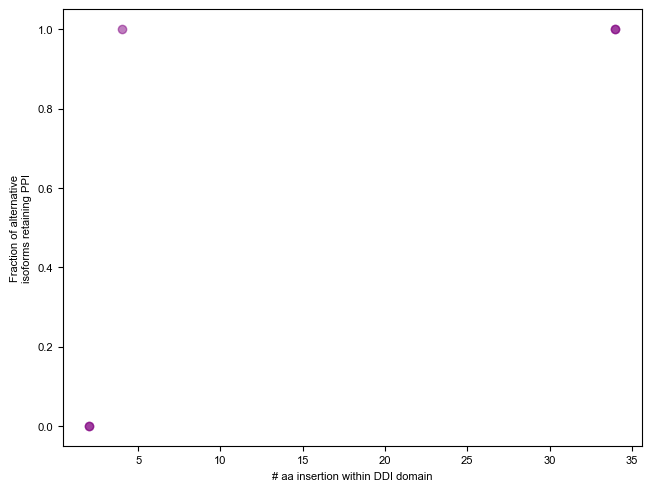

In [28]:
# kaia added these lines because type conversion wasn't working
nonan = df.loc[df['Y2H_result'].notnull() & (df['insertion_in_DDI_domains'] > 0), :]
nonan['Y2H_result'] = nonan['Y2H_result'].astype(int)

x = nonan.groupby(['ad_iso_id', 'tf_domains'])['insertion_in_DDI_domains'].mean().values
y = nonan.groupby(['ad_iso_id', 'tf_domains'])['Y2H_result'].mean().values

fig, ax = plt.subplots(1, 1)
ax.scatter(x, y, alpha=0.5, color='purple')
ax.set_ylabel('Fraction of alternative\nisoforms retaining PPI')
ax.set_xlabel('# aa insertion within DDI domain')
fig.savefig('../figures/PPI_vs_domain_insertion.pdf', bbox_inches='tight')

In [29]:
# break down DDI vs DMI etc etc.

<AxesSubplot: ylabel='is_same_family_tf'>

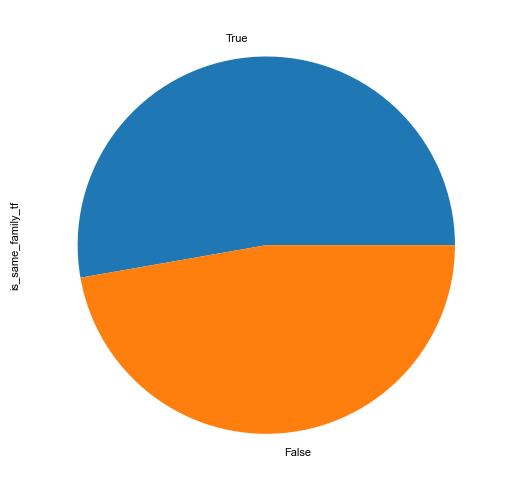

In [30]:
(ggi.loc[ggi['is_tf_tf'], 
        'is_same_family_tf']
.value_counts()
.plot.pie())

In [31]:
cof = load_cofactors()
ggi['is_tf_cf'] = ggi['db_gene_symbol'].isin(cof['Symbol'].values)

In [32]:
(~ggi['is_tf_tf'] & ggi['is_tf_cf']).mean()

0.14945848375451262

In [33]:
from data_loading import load_ppi_partner_categories

cats = load_ppi_partner_categories()

reading from cache
reading from cache


<AxesSubplot: ylabel='category'>

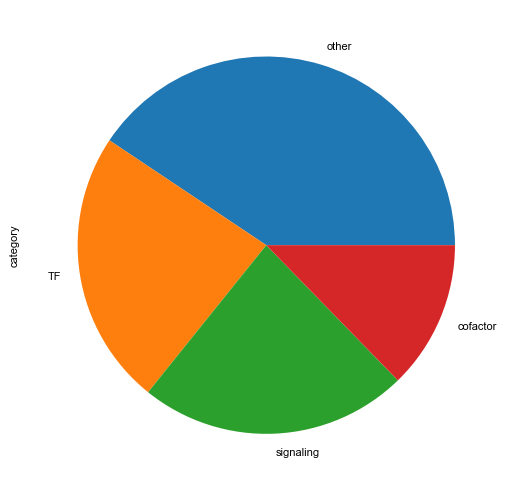

In [34]:
# this is by partner, plot by PPI instead
cats['category'].value_counts().plot.pie()

In [35]:
cats.loc[cats['category'] == 'nuclear transport']

,gene_symbol_partner,category,cofactor_type


In [36]:
ggi.loc[ggi['db_gene_symbol'].isin(
        cats.loc[cats['category'] == 'nuclear transport',
                 'gene_symbol_partner'].values)]

,ad_gene_symbol,db_gene_symbol,db_orf_id,matching_DDI,matching_DDI_filtered,DDI,is_tf_tf,is_same_family_tf,slim_binding_domains_in_partner,putative_DMI,slim_binding_domains_in_tf,is_tf_cf


In [37]:
cats.head()

,gene_symbol_partner,category,cofactor_type
0,ATF2,TF,NaN
1,COL8A1,other,NaN
2,EFEMP2,other,NaN
3,FOSL2,TF,NaN
4,JDP2,TF,NaN


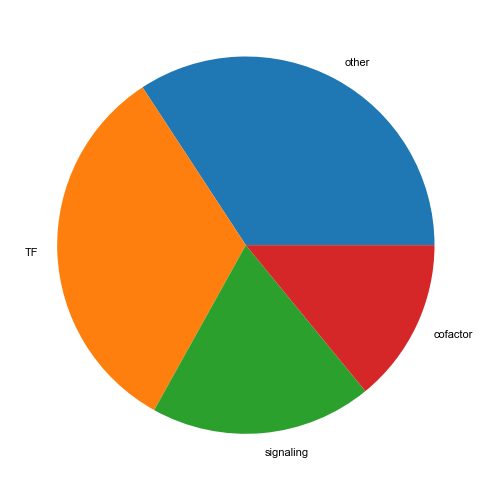

In [38]:
fig, ax = plt.subplots(1, 1)
(ggi['db_gene_symbol']
.map(cats.drop_duplicates('gene_symbol_partner').set_index('gene_symbol_partner')['category'])
.value_counts()
.plot.pie(ax=ax))
ax.set_ylabel('')
fig.savefig('../figures/PPIs-gene-level-manual-categories_pie.pdf',
            bbox_inches='tight')

In [39]:
ggi['db_gene_symbol'].map(cats.drop_duplicates('gene_symbol_partner').set_index('gene_symbol_partner')['category']).value_counts()

other        474
TF           453
signaling    263
cofactor     195
Name: db_gene_symbol, dtype: int64

In [40]:
ggi['db_gene_symbol'].map(cats.drop_duplicates('gene_symbol_partner').set_index('gene_symbol_partner')['category']).value_counts().sum()

1385

In [41]:
print(len(ggi))
ggi = ggi.merge(cats, left_on='db_gene_symbol', right_on='gene_symbol_partner').drop_duplicates()
print(len(ggi))
ggi.cofactor_type.value_counts()

1385
1385


unknown        126
coactivator     31
corepressor     25
both            13
Name: cofactor_type, dtype: int64

<AxesSubplot: ylabel='partner_category'>

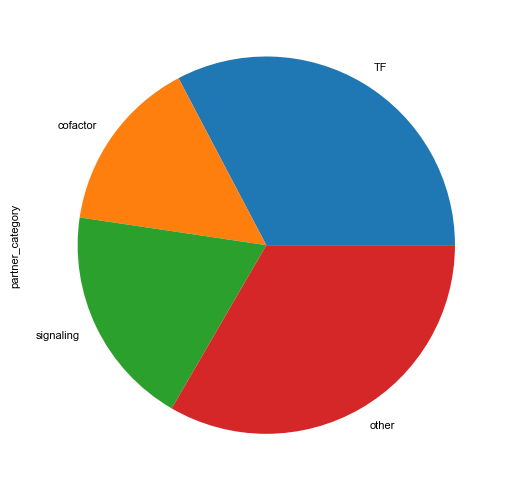

In [42]:
def categorize_PPI_partner(row):
    if row['is_tf_tf']:
        return 'TF'
    elif row['is_tf_cf']:
        return 'cofactor'
    elif row['category'] == "signaling":
        return 'signaling'
    else:
        return 'other'

ggi['partner_category'] = ggi.apply(categorize_PPI_partner, axis=1)
ggi['partner_category'].value_counts()[['TF', 'cofactor', 'signaling', 'other']].plot.pie()

In [43]:
len(ggi)

1385

In [44]:
len(ggi.db_gene_symbol.unique())

751

In [45]:
ggi['partner_category'].value_counts()

other        462
TF           453
signaling    263
cofactor     207
Name: partner_category, dtype: int64

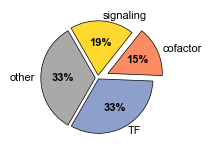

In [46]:
ys = np.array([len(ggi[ggi["partner_category"] == "TF"]), len(ggi[ggi["partner_category"] == "cofactor"]),
               len(ggi[ggi["partner_category"] == "signaling"]),
              len(ggi[ggi["partner_category"] == "other"])])
labels = ["TF", "cofactor", "signaling", "other"]
colors = [sns.color_palette("Set2")[2], sns.color_palette("Set2")[1], sns.color_palette("Set2")[5], "darkgray"]

fig, ax = plt.subplots(figsize=(2.0, 2.0), subplot_kw=dict(aspect="equal"))
ws, ls, ns = ax.pie(ys, colors=colors, labels=labels, autopct='%1.0f%%', startangle=-120, 
                    explode=(0.02, 0.2, 0.05, 0.05))

for n, w in zip(ns, ws):
    w.set_linewidth(0.5)
    w.set_edgecolor("black")
    n.set_fontweight("bold")

fig.savefig("../figures/PPIs-gene-level-manual-categories_simplified.pdf", dpi="figure", bbox_inches="tight")

In [47]:
ggi[ggi["partner_category"] != "cofactor"].cofactor_type.value_counts()

Series([], Name: cofactor_type, dtype: int64)

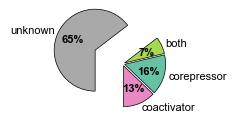

In [48]:
cofacs = ggi[ggi["partner_category"] == "cofactor"]

ys = np.array([len(cofacs[cofacs["cofactor_type"] == "corepressor"]), 
               len(cofacs[cofacs["cofactor_type"] == "coactivator"]),
               len(cofacs[cofacs["cofactor_type"] == "both"]),
               len(cofacs[cofacs["cofactor_type"] == "unknown"])])
labels = ["coactivator", "corepressor", "both", "unknown"]
colors = [sns.color_palette("Set2")[3], sns.color_palette("Set2")[0], sns.color_palette("Set2")[4], "darkgray"]

fig, ax = plt.subplots(figsize=(2.25, 2.25), subplot_kw=dict(aspect="equal"))
ws, ls, ns = ax.pie(ys, colors=colors, labels=labels, autopct='%1.0f%%', startangle=-90, 
                    explode=(0.05, 0.05, 0.05, 0.75))

for n, w in zip(ns, ws):
    w.set_linewidth(0.5)
    w.set_edgecolor("black")
    n.set_fontweight("bold")

fig.savefig("../figures/PPIs-gene-level-manual-categories_cofactors.pdf", dpi="figure", bbox_inches="tight")

In [49]:
# RNA binding proteins
rbp = pd.read_csv('../data/external/RBPDB_v1.3.1_proteins_human_2012-11-21.tdt',
                 sep='\t',
                 header=None)
# BUG: there are 10 genes missing names
rbp = set(rbp.loc[rbp.loc[:, 4].notnull(), 4].unique())
ggi['is_tf_rbp'] = ggi['db_gene_symbol'].isin(rbp)
(~ggi['is_tf_tf'] & ~ggi['is_tf_cf'] & ggi['is_tf_rbp']).mean()

0.012996389891696752

In [50]:
# kinase / phosphatase
from Bio import SeqIO

kinase_genes = {r.description.split()[2][len('gene='):] for r in SeqIO.parse('../data/external/human_kinases.fa', 'fasta')}
ggi['is_tf_kinase'] = ggi['db_gene_symbol'].isin(kinase_genes)
(~ggi['is_tf_tf'] & ~ggi['is_tf_cf'] & ggi['is_tf_kinase']).mean()

0.019494584837545126

In [51]:
# relation of domain loss to DDI PPI loss

In [52]:
pair = ('PF00023', 'PF16179')
pair = ('PF12796', 'PF16179')
pair = ('PF00010',	'PF00989')
pair = ('PF00505',	'PF00505')

pair = ('PF00989',	'PF00989')
pair = ('PF00989',	'PF14598')
#pair = ('PF00989',	'PF08447')
#pair = ('PF08447',	'PF08447')

# NPAS2	ARNTL
# NPAS2	ARNTL2
# ARNT2	SIM1
# HIF1A	ARNTL

pair = ('PF00170',	'PF00170')

ggi.loc[ggi['matching_DDI'].apply(lambda x: not pd.isnull(x) and pair in x)]

,ad_gene_symbol,db_gene_symbol,db_orf_id,matching_DDI,matching_DDI_filtered,DDI,is_tf_tf,is_same_family_tf,slim_binding_domains_in_partner,putative_DMI,slim_binding_domains_in_tf,is_tf_cf,gene_symbol_partner,category,cofactor_type,partner_category,is_tf_rbp,is_tf_kinase
0,ATF2,ATF2,54731,"((PF00170, PF07716), (PF00170, PF00170))","((PF00170, PF00170))",bZIP_1|bZIP_1,True,True,NaN,False,NaN,False,ATF2,TF,NaN,TF,False,False
1,FOS,ATF2,54731,"((PF00170, PF07716), (PF00170, PF00170))","((PF00170, PF00170))",bZIP_1|bZIP_1,True,True,NaN,False,NaN,False,ATF2,TF,NaN,TF,False,False
3,FOSB,ATF2,54731,"((PF00170, PF07716), (PF00170, PF00170))","((PF00170, PF00170))",bZIP_1|bZIP_1,True,True,NaN,False,NaN,False,ATF2,TF,NaN,TF,False,False
4,ATF2,FOSL2,12504,"((PF00170, PF07716), (PF00170, PF00170))","((PF00170, PF00170))",bZIP_1|bZIP_1,True,True,NaN,False,NaN,False,FOSL2,TF,NaN,TF,False,False
5,CREB5,FOSL2,12504,"((PF00170, PF07716), (PF00170, PF00170))","((PF00170, PF00170))",bZIP_1|bZIP_1,True,True,NaN,False,NaN,False,FOSL2,TF,NaN,TF,False,False
7,ATF2,JDP2,13624,"((PF00170, PF03131), (PF00170, PF07716), (PF00170, PF00170))","((PF00170, PF00170))",bZIP_1|bZIP_1,True,True,NaN,False,NaN,False,JDP2,TF,NaN,TF,False,False
8,CREB5,JDP2,13624,"((PF00170, PF03131), (PF00170, PF07716), (PF00170, PF00170))","((PF00170, PF00170))",bZIP_1|bZIP_1,True,True,NaN,False,NaN,False,JDP2,TF,NaN,TF,False,False
609,FOS,JUNB,4265,"((PF00170, PF03131), (PF00170, PF07716), (PF00170, PF00170))","((PF00170, PF00170))",bZIP_1|bZIP_1,True,True,NaN,False,NaN,False,JUNB,TF,NaN,TF,False,False
610,FOSB,JUNB,4265,"((PF00170, PF03131), (PF00170, PF07716), (PF00170, PF00170))","((PF00170, PF00170))",bZIP_1|bZIP_1,True,True,NaN,False,NaN,False,JUNB,TF,NaN,TF,False,False


In [53]:
pair = ('PF03166',	'PF03166')
ggi.loc[ggi['matching_DDI'].apply(lambda x: not pd.isnull(x) and pair in x)]

,ad_gene_symbol,db_gene_symbol,db_orf_id,matching_DDI,matching_DDI_filtered,DDI,is_tf_tf,is_same_family_tf,slim_binding_domains_in_partner,putative_DMI,slim_binding_domains_in_tf,is_tf_cf,gene_symbol_partner,category,cofactor_type,partner_category,is_tf_rbp,is_tf_kinase
518,SMAD4,SMAD1,3782,"((PF03165, PF03165), (PF03166, PF03166))","((PF03165, PF03165), (PF03166, PF03166))",MH1|MH1 and MH2|MH2,True,True,NaN,False,NaN,False,SMAD1,TF,NaN,TF,False,False
519,SMAD4,SMAD9,7123,"((PF03165, PF03165), (PF03166, PF03166))","((PF03165, PF03165), (PF03166, PF03166))",MH1|MH1 and MH2|MH2,True,True,NaN,False,NaN,False,SMAD9,TF,NaN,TF,False,False


In [54]:
pair = ('PF03166',	'PF08782')
ggi.loc[ggi['matching_DDI'].apply(lambda x: not pd.isnull(x) and pair in x)]

,ad_gene_symbol,db_gene_symbol,db_orf_id,matching_DDI,matching_DDI_filtered,DDI,is_tf_tf,is_same_family_tf,slim_binding_domains_in_partner,putative_DMI,slim_binding_domains_in_tf,is_tf_cf,gene_symbol_partner,category,cofactor_type,partner_category,is_tf_rbp,is_tf_kinase
516,SMAD4,SKI,100062305,"((PF03166, PF08782), (PF08782, PF03166))","((PF03166, PF08782))",MH2|c-SKI_SMAD_bind,True,False,NaN,False,NaN,True,SKI,TF,NaN,TF,False,False
517,SMAD3,SKI,100062305,"((PF03166, PF08782), (PF08782, PF03166))","((PF03166, PF08782))",MH2|c-SKI_SMAD_bind,True,False,NaN,False,NaN,True,SKI,TF,NaN,TF,False,False


In [55]:
pair = ('PF07714',	'PF00017')
ggi.loc[ggi['matching_DDI'].apply(lambda x: not pd.isnull(x) and pair in x)]

,ad_gene_symbol,db_gene_symbol,db_orf_id,matching_DDI,matching_DDI_filtered,DDI,is_tf_tf,is_same_family_tf,slim_binding_domains_in_partner,putative_DMI,slim_binding_domains_in_tf,is_tf_cf,gene_symbol_partner,category,cofactor_type,partner_category,is_tf_rbp,is_tf_kinase
417,STAT3,TXK,100066358,"((PF00017, PF00017), (PF00017, PF00018), (PF07714, PF00017))",NaN,NaN,False,False,"(PF00017, PF00069, PF14604, PF00018, PF07714)",True,(PF00017),False,TXK,signaling,NaN,signaling,False,True
863,STAT3,BLK,5424,"((PF00017, PF00017), (PF00017, PF00018), (PF07714, PF00017), (PF00017, PF07653))",NaN,NaN,False,False,"(PF00017, PF00069, PF14604, PF07653, PF00018, PF07714)",True,(PF00017),False,BLK,signaling,NaN,signaling,False,True
864,STAT3,BMX,842,"((PF00017, PF00017), (PF07714, PF00017))",NaN,NaN,False,False,"(PF00069, PF00017, PF07714)",True,(PF00017),False,BMX,signaling,NaN,signaling,False,True
866,STAT3,ERBB2,100062227,"((PF07714, PF00017))",NaN,NaN,False,False,"(PF00069, PF07714)",True,(PF00017),True,ERBB2,cofactor,unknown,cofactor,False,False


In [56]:
ggi.loc[ggi['matching_DDI'].apply(lambda x: not pd.isnull(x) and ('PF00023', 'PF16179') in x)]

,ad_gene_symbol,db_gene_symbol,db_orf_id,matching_DDI,matching_DDI_filtered,DDI,is_tf_tf,is_same_family_tf,slim_binding_domains_in_partner,putative_DMI,slim_binding_domains_in_tf,is_tf_cf,gene_symbol_partner,category,cofactor_type,partner_category,is_tf_rbp,is_tf_kinase
642,RELA,CDKN2D,3933,"((PF00023, PF16179), (PF12796, PF16179))","((PF00023, PF16179))",Ank|RHD_dimer,False,False,(PF00023),True,NaN,False,CDKN2D,signaling,NaN,signaling,False,False
1213,RELA,ASAP3,10898,"((PF00023, PF16179), (PF12796, PF16179))","((PF00023, PF16179))",Ank|RHD_dimer,False,False,(PF00023),True,NaN,False,ASAP3,other,NaN,other,False,False
1361,RELA,NFKBIB,745,"((PF00023, PF16179), (PF12796, PF16179))","((PF00023, PF16179))",Ank|RHD_dimer,False,False,(PF00023),True,NaN,True,NFKBIB,cofactor,coactivator,cofactor,False,False


In [57]:
# proportion of gene-level PPIs where the partner has a slim binding domain
# or the TF has a slim binding domain
ggi.head()

,ad_gene_symbol,db_gene_symbol,db_orf_id,matching_DDI,matching_DDI_filtered,DDI,is_tf_tf,is_same_family_tf,slim_binding_domains_in_partner,putative_DMI,slim_binding_domains_in_tf,is_tf_cf,gene_symbol_partner,category,cofactor_type,partner_category,is_tf_rbp,is_tf_kinase
0,ATF2,ATF2,54731,"((PF00170, PF07716), (PF00170, PF00170))","((PF00170, PF00170))",bZIP_1|bZIP_1,True,True,NaN,False,NaN,False,ATF2,TF,NaN,TF,False,False
1,FOS,ATF2,54731,"((PF00170, PF07716), (PF00170, PF00170))","((PF00170, PF00170))",bZIP_1|bZIP_1,True,True,NaN,False,NaN,False,ATF2,TF,NaN,TF,False,False
2,ZNF451,ATF2,54731,NaN,NaN,NaN,True,False,NaN,False,NaN,False,ATF2,TF,NaN,TF,False,False
3,FOSB,ATF2,54731,"((PF00170, PF07716), (PF00170, PF00170))","((PF00170, PF00170))",bZIP_1|bZIP_1,True,True,NaN,False,NaN,False,ATF2,TF,NaN,TF,False,False
4,ATF2,FOSL2,12504,"((PF00170, PF07716), (PF00170, PF00170))","((PF00170, PF00170))",bZIP_1|bZIP_1,True,True,NaN,False,NaN,False,FOSL2,TF,NaN,TF,False,False


In [58]:
print(ppi.loc[:, ['ad_gene_symbol', 'db_gene_symbol']].drop_duplicates().shape[0],
      'gene level PPIs')
print(ppi.loc[ppi['db_orf_id'].isin(orfs_with_slim_dom),
              ['ad_gene_symbol', 'db_gene_symbol']].drop_duplicates().shape[0],
      'gene level PPIs involving motif binding domain')

1385 gene level PPIs
395 gene level PPIs involving motif binding domain


In [59]:
dom_slim_ppi = set(ppi.loc[ppi['db_orf_id'].isin(orfs_with_slim_dom),
                       'gene_level_pair'].unique())
pos_ppi = set(ppi.loc[(ppi['Y2H_result'] == True), 'gene_level_pair'].unique())
neg_ppi = set(ppi.loc[(ppi['Y2H_result'] == False), 'gene_level_pair'].unique())
diff_slim_ppi = dom_slim_ppi.intersection(pos_ppi.intersection(neg_ppi))
print(len(diff_slim_ppi), 
      'gene-level PPIs where partner has SLiM binding domain and some isoforms bind and some dont')
print('involving {} TF genes'.format(len({p.split('_')[0] for p in diff_slim_ppi})))

200 gene-level PPIs where partner has SLiM binding domain and some isoforms bind and some dont
involving 53 TF genes


In [60]:
def match_elm_motifs(orfs, elm):
    """Take the ELM motifs file and match the regex to given aa seqs
    Args:
        orfs (Series): amino acid sequences indexed by ORF ID
    Returns:
        DataFrame: one row for each seperate match of a motif to an ORF
    """
    motifs = []
    for elmIdx, elmRow in elm.iterrows():
        # inserting ?: to make groups non-capture
        motifMatches = orfs.str.findall(elmRow['Regex'].replace('(', '(?:'))
        for orfID, matches in zip(motifMatches.index, motifMatches.values):
            for match in matches:
                start = orfs.loc[orfID].find(match)
                # switch from 0 to 1-based indexing
                motifs.append((orfID,
                               elmRow['Accession'],
                               elmRow['ELMIdentifier'],
                               start + 1,
                               start + len(match)))
    motifs = pd.DataFrame(data=motifs,
                          columns=('orf_id', 'region_id', 'ELM_ID', 'start', 'end'))
    motifs['source'] = 'ELM_prediction'
    motifs['type'] = 'SLiM'
    return motifs


slims = match_elm_motifs(iso['aa_seq'], elm)

In [61]:
slims

,orf_id,region_id,ELM_ID,start,end,source,type
0,ARNT2|1/6|08C12,ELME000321,CLV_C14_Caspase3-7,144,148,ELM_prediction,SLiM
1,ARNT2|1/6|08C12,ELME000321,CLV_C14_Caspase3-7,481,485,ELM_prediction,SLiM
2,ARNT2|2/6|09E01,ELME000321,CLV_C14_Caspase3-7,133,137,ELM_prediction,SLiM
3,ARNT2|2/6|09E01,ELME000321,CLV_C14_Caspase3-7,470,474,ELM_prediction,SLiM
4,ARNT2|3/6|10D11,ELME000321,CLV_C14_Caspase3-7,144,148,ELM_prediction,SLiM
...,...,...,...,...,...,...,...
94991,TBX18|3/3|01F09,ELME000009,TRG_PTS1,229,232,ELM_prediction,SLiM
94992,ZNF394|1/3|09F09,ELME000009,TRG_PTS1,558,561,ELM_prediction,SLiM
94993,ZNF418|2/2|04G04,ELME000009,TRG_PTS1,125,128,ELM_prediction,SLiM
94994,ZNF655|3/6|03B05,ELME000009,TRG_PTS1,178,181,ELM_prediction,SLiM


In [62]:
def isoform_specific_regions(gene, subset=None):
    """The name is a bit misleading because it's not specific to one isoform but just
       not common to all isoforms.

    Returns: dict(frozenset: list(str)): isoform IDs and list of contiguous AA sequences
                                         that map to them only 

    """
    algn = gene.genomic_alignment_of_aa_seqs(subset=subset)
    subset_prev = None
    isr = {}
    len_algn = len(list(algn.values())[0])
    for i in range(len_algn):
        subset = frozenset({k for k, v in algn.items() if v[i] != '-'})  # the isoforms that have an aa at that genomic position
        if subset_prev is None:
            if (len(subset) < len(algn)) and (len(subset) > 0):
                start = i
                subset_prev = subset
        else:
            if subset != subset_prev:
                if (len(subset_prev) < len(algn)) and (len(subset_prev) > 0):
                    subseq = (algn[list(subset_prev)[0]][start:i], start, i)
                    isr[subset_prev] = isr.get(subset_prev, []) + [subseq]
                start = i
                subset_prev = subset
            elif  i == (len_algn - 1):
                if (len(subset_prev) < len(algn)) and (len(subset_prev) > 0):
                    subseq = (algn[list(subset_prev)[0]][start:], start, i + 1)
                    isr[subset_prev] = isr.get(subset_prev, []) + [subseq]
                start = i
                subset_prev = subset
    merged = {}
    for iso_subset, subseqs in isr.items():
        merged[iso_subset] = []
        prev_end = np.inf
        prev_subseq = ''
        for subseq, start, end in subseqs:
            if start <= prev_end + 2:
                prev_subseq += subseq
                prev_end = end
            else:
                if prev_subseq != '':
                    merged[iso_subset].append(prev_subseq)
                prev_subseq = subseq
                prev_end = end
        merged[iso_subset].append(prev_subseq)
    return merged


def ppi_tf_gene(data, gene_name):
    tf = data.loc[(data['category'] == 'tf_isoform_ppis') &
                (data['ad_gene_symbol'] == gene_name),
                ['ad_clone_name', 'db_gene_symbol', 'Y2H_result']].copy()
    tf = tf.pivot(index='ad_clone_name',
                  columns='db_gene_symbol',
                  values='Y2H_result')
    return tf


def ppi_linked_isoform_specific_regions(ppi_data, gene):
    """
    For now, do not use cases where there are missing values
    """
    isr = isoform_specific_regions(gene, subset={iso.name for iso in gene.cloned_isoforms})
    ppi = ppi_tf_gene(ppi_data, gene.name)
    ppi_isr = {}
    ppi_iso = {partner: set(ppi.index[ppi[partner]])
               for partner in ppi.columns
               if ppi[partner].notnull().all()}
    for partner, ppi_iso_subset in ppi_iso.items():
        for isr_subset, aa_seqs in isr.items():
            if ppi_iso_subset == isr_subset:
                ppi_isr[partner] = (isr_subset, aa_seqs)
    return ppi_isr

In [63]:
slim_binding_domains = pd.merge(pfam,
                                dlm,
                                how='inner',
                                left_on='pfam_accession',
                                right_on='Interaction Domain Id')
slim_binding_domains = pd.merge(slim_binding_domains,
                                ppi,
                                how='inner',
                                left_on='orf_id',
                                right_on='db_orf_id')
slim_ppis = slim_binding_domains.loc[:, ['ad_gene_symbol', 
                                        'db_gene_symbol',
                                        'pfam_accession',
                                        'domain_name',
                                        'domain_description',
                                        'ELM identifier']].drop_duplicates()
ppi_isr = {}
for gene_name in slim_ppis['ad_gene_symbol'].unique():
    if gene_name not in tfs:
        print(gene_name, 'missing')
        continue
    ppi_isr[gene_name] = ppi_linked_isoform_specific_regions(ppi, tfs[gene_name])
slim_ppis = slim_ppis.loc[slim_ppis.apply(lambda x: x['db_gene_symbol'] in ppi_isr[x['ad_gene_symbol']],
                              axis=1),
              :]
slim_ppis['aa_seq_isr'] = slim_ppis.apply(lambda x: ppi_isr[x['ad_gene_symbol']][x['db_gene_symbol']][1], axis=1)

In [64]:
def isr_contains_slim(row):
    # inserting ?: to make groups non-capture
    if row['ELM identifier'] not in elm['ELMIdentifier'].values:
        #raise UserWarning('Missing ELM entry for: ', row['ELM identifier'])
        print('Missing ELM entry for: ', row['ELM identifier'])
        return False
    regex = elm.loc[elm['ELMIdentifier'] == row['ELM identifier'], 'Regex'].values[0].replace('(', '(?:')
    return any(bool(re.search(regex, aa_seq)) for aa_seq in row['aa_seq_isr'])


slim_ppis['slim_match'] = slim_ppis.apply(isr_contains_slim, axis=1)

Missing ELM entry for:  MOD_PLK
Missing ELM entry for:  MOD_PLK
Missing ELM entry for:  MOD_PLK
Missing ELM entry for:  LIG_CaM_1-26_7
Missing ELM entry for:  LIG_CaM_1-17_6
Missing ELM entry for:  LIG_CaM_1-8-9-10_5
Missing ELM entry for:  LIG_CaM_1-8-14_4
Missing ELM entry for:  LIG_CaM_1-5-10-14_3
Missing ELM entry for:  LIG_CaM_1-8_REV_2
Missing ELM entry for:  LIG_CaM_1-14-15-16_REV_1
Missing ELM entry for:  LIG_CaM_1-26_7
Missing ELM entry for:  LIG_CaM_1-17_6
Missing ELM entry for:  LIG_CaM_1-8-9-10_5
Missing ELM entry for:  LIG_CaM_1-8-14_4
Missing ELM entry for:  LIG_CaM_1-5-10-14_3
Missing ELM entry for:  LIG_CaM_1-8_REV_2
Missing ELM entry for:  LIG_CaM_1-14-15-16_REV_1
Missing ELM entry for:  LIG_CaM_1-26_7
Missing ELM entry for:  LIG_CaM_1-17_6
Missing ELM entry for:  LIG_CaM_1-8-9-10_5
Missing ELM entry for:  LIG_CaM_1-8-14_4
Missing ELM entry for:  LIG_CaM_1-5-10-14_3
Missing ELM entry for:  LIG_CaM_1-8_REV_2
Missing ELM entry for:  LIG_CaM_1-14-15-16_REV_1
Missing ELM e

In [65]:
slim_ppis['slim_match'].sum()

158

In [66]:
slim_ppis.loc[slim_ppis['slim_match'] & (slim_ppis['db_gene_symbol'] == 'TXK')].sort_values('ad_gene_symbol')

,ad_gene_symbol,db_gene_symbol,pfam_accession,domain_name,domain_description,ELM identifier,aa_seq_isr,slim_match
3995,STAT3,TXK,PF00069,Pkinase,Protein kinase domain,MOD_CK1_1,[MAQWNQLQQLDTRYLEQLHQLYSDSFPMELRQFLAPWIESQDWAYAASKESHATLVFHNLLGEIDQQYSRFLQESNVLYQHNLRRIKQFLQSRYLEKP],True
4175,STAT3,TXK,PF00069,Pkinase,Protein kinase domain,MOD_NEK2_1,[MAQWNQLQQLDTRYLEQLHQLYSDSFPMELRQFLAPWIESQDWAYAASKESHATLVFHNLLGEIDQQYSRFLQESNVLYQHNLRRIKQFLQSRYLEKP],True
4343,STAT3,TXK,PF00069,Pkinase,Protein kinase domain,MOD_Plk_4,[MAQWNQLQQLDTRYLEQLHQLYSDSFPMELRQFLAPWIESQDWAYAASKESHATLVFHNLLGEIDQQYSRFLQESNVLYQHNLRRIKQFLQSRYLEKP],True
4439,STAT3,TXK,PF00017,SH2,SH2 domain,LIG_SH2_STAT3,[MAQWNQLQQLDTRYLEQLHQLYSDSFPMELRQFLAPWIESQDWAYAASKESHATLVFHNLLGEIDQQYSRFLQESNVLYQHNLRRIKQFLQSRYLEKP],True
4451,STAT3,TXK,PF00017,SH2,SH2 domain,LIG_SH2_STAT5,[MAQWNQLQQLDTRYLEQLHQLYSDSFPMELRQFLAPWIESQDWAYAASKESHATLVFHNLLGEIDQQYSRFLQESNVLYQHNLRRIKQFLQSRYLEKP],True
4535,STAT3,TXK,PF00017,SH2,SH2 domain,LIG_SH2_STAP1,[MAQWNQLQQLDTRYLEQLHQLYSDSFPMELRQFLAPWIESQDWAYAASKESHATLVFHNLLGEIDQQYSRFLQESNVLYQHNLRRIKQFLQSRYLEKP],True


In [67]:
# use disordered info
slim_ppis

,ad_gene_symbol,db_gene_symbol,pfam_accession,domain_name,domain_description,ELM identifier,aa_seq_isr,slim_match
0,TCF4,KLC3,PF00515,TPR_1,Tetratricopeptide repeat,LIG_TPR,[MHHQQRMAALGTDKELSDLLDFSAMFSPPVSSGKNGPTSLASGHFTGSNVEDRSSSGSWGNGGHPSPSRNYGDGTPYDHMTSRDLGSHDNLSPPFVNSRIQSKTERGSYSSYGRESNLQGCHQSLLGGD],False
8,TCF4,KLC3,PF00515,TPR_1,Tetratricopeptide repeat,TRG_PTS1,[MHHQQRMAALGTDKELSDLLDFSAMFSPPVSSGKNGPTSLASGHFTGSNVEDRSSSGSWGNGGHPSPSRNYGDGTPYDHMTSRDLGSHDNLSPPFVNSRIQSKTERGSYSSYGRESNLQGCHQSLLGGD],False
16,TCF4,KLC3,PF00515,TPR_1,Tetratricopeptide repeat,LIG_APCC_Cbox_2,[MHHQQRMAALGTDKELSDLLDFSAMFSPPVSSGKNGPTSLASGHFTGSNVEDRSSSGSWGNGGHPSPSRNYGDGTPYDHMTSRDLGSHDNLSPPFVNSRIQSKTERGSYSSYGRESNLQGCHQSLLGGD],False
24,TCF4,KLC3,PF00515,TPR_1,Tetratricopeptide repeat,LIG_APCC_Cbox_1,[MHHQQRMAALGTDKELSDLLDFSAMFSPPVSSGKNGPTSLASGHFTGSNVEDRSSSGSWGNGGHPSPSRNYGDGTPYDHMTSRDLGSHDNLSPPFVNSRIQSKTERGSYSSYGRESNLQGCHQSLLGGD],False
552,PRRX1,HOXA1,PF00046,Homeobox,Homeobox domain,LIG_HOMEOBOX,[SSSLPRCCLHEGLHNGF],False
...,...,...,...,...,...,...,...,...
22278,PAX5,HGS,PF00790,VHS,VHS domain,TRG_LysEnd_GGAAcLL_2,[MDLEKNYPTPRTSRTGHGGVNQLGGVFVNGRPLPDVVRQRIVELAHQGVRPCDISRQLRVSHGCVSKILGRYYETGSIKPGVIGGSKPKVATPKVVEKIAEYKRQNPT],False
22286,NFIX,MLH1,PF16413,Mlh1_C,DNA mismatch repair protein Mlh1 C-terminus,LIG_MLH1_MIPbox_1,[GSPRATASALHFPSTSIIQQSSPYFTHPTIRYHHHHGQDSLKEFVQFVCSDGSGQATGQHSQRQAPPLPTGLSASDPGTATF],True
22305,MEOX1,CKS1B,PF01111,CKS,Cyclin-dependent kinase regulatory subunit,DOC_CKS1_1,[MDPAASSCMRSLQPPAPVWGCLRNPHSEGNGASGLPHYPPTPFSFHQKPDFLATATAAYPDFSASCLAATPHSLPQEEHIFTEQHPAFPQSPNWHFPVSDARRRPNSGPAGGSKE],True
22335,IKZF2,CTBP2,PF00389,2-Hacid_dh,"D-isomer specific 2-hydroxyacid dehydrogenase, catalytic domain",LIG_CtBP_PxDLS_1,"[M, S, GKLKCDVCGMVCIGPNVLMVHKRSHT]",False


In [68]:
slim_ppis.loc[slim_ppis['slim_match'], 'ELM identifier'].value_counts()

MOD_NEK2_1           15
MOD_Plk_4            14
MOD_GSK3_1           13
MOD_CK1_1            12
MOD_ProDKin_1        12
MOD_PKA_2             9
MOD_Plk_1             8
MOD_CK2_1             8
DOC_WW_Pin1_4         5
MOD_CDK_SPxK_1        4
LIG_SH2_STAT5         4
MOD_CDK_SPK_2         3
DOC_MAPK_gen_1        3
MOD_NEK2_2            3
MOD_LATS_1            3
DOC_PP2B_LxvP_1       3
DOC_MAPK_MEF2A_6      3
LIG_SH3_3             3
LIG_SH2_STAT3         3
LIG_SH2_STAP1         3
MOD_PKA_1             2
DOC_MAPK_HePTP_8      2
MOD_CDK_SPxxK_3       2
LIG_EVH1_2            1
MOD_SUMO_for_1        1
LIG_MLH1_MIPbox_1     1
DOC_CKS1_1            1
LIG_EVH1_1            1
CLV_PCSK_KEX2_1       1
CLV_PCSK_SKI1_1       1
CLV_PCSK_PC1ET2_1     1
CLV_PCSK_FUR_1        1
DOC_ANK_TNKS_1        1
LIG_NRBOX             1
LIG_HCF-1_HBM_1       1
MOD_Plk_2-3           1
DOC_MAPK_NFAT4_5      1
MOD_PK_1              1
MOD_PKB_1             1
TRG_ER_diArg_1        1
LIG_SH2_NCK_1         1
LIG_SH2_CRK     

In [69]:
slim_ppis.loc[slim_ppis['slim_match'] & (slim_ppis['ELM identifier'] == 'LIG_SH3_3')]

,ad_gene_symbol,db_gene_symbol,pfam_accession,domain_name,domain_description,ELM identifier,aa_seq_isr,slim_match
2361,FOSB,NCK2,PF00018,SH3_1,SH3 domain,LIG_SH3_3,[VRDLPGSAPAKEDGFSWLLPPPPPPPLPFQTSQDAPPNLTASLFTHSEVQVLGDPFPVVNPSYTSSFVLTCPEVSAFAGAQRTSGSDQPSDPLNSPSLLAL],True
3597,PAX5,STAC,PF00018,SH3_1,SH3 domain,LIG_SH3_3,[MDLEKNYPTPRTSRTGHGGVNQLGGVFVNGRPLPDVVRQRIVELAHQGVRPCDISRQLRVSHGCVSKILGRYYETGSIKPGVIGGSKPKVATPKVVEKIAEYKRQNPT],True
3631,MEIS2,HCK,PF00018,SH3_1,SH3 domain,LIG_SH3_3,"[MAQRYDELPHYGG, GLQSMPGDYVSQGGPMGMSMAQPSYTPPQMTPHPTQLRHGPPMHSYLPSHPHHPAMMMHGGPPTHPGMTMSAQSPTMLNSVDPNVGGQVMDIHAQ]",True


In [70]:
slim_ppis.loc[slim_ppis['ad_gene_symbol'] == 'PBX1']

,ad_gene_symbol,db_gene_symbol,pfam_accession,domain_name,domain_description,ELM identifier,aa_seq_isr,slim_match
21617,PBX1,PIN1,PF00397,WW,WW domain,LIG_WW_1,[GSSSSFNMSNSGDLFMSVQSLNGDSYQGAQVGANVQSQVDTLRHVISQTGGYSDGLAASQMYSPQGISANGGWQDATTPSSVTSPTEGPGSVHSDTSN],False
21658,PBX1,PIN1,PF00397,WW,WW domain,LIG_WW_2,[GSSSSFNMSNSGDLFMSVQSLNGDSYQGAQVGANVQSQVDTLRHVISQTGGYSDGLAASQMYSPQGISANGGWQDATTPSSVTSPTEGPGSVHSDTSN],False
21699,PBX1,PIN1,PF00397,WW,WW domain,LIG_WW_3,[GSSSSFNMSNSGDLFMSVQSLNGDSYQGAQVGANVQSQVDTLRHVISQTGGYSDGLAASQMYSPQGISANGGWQDATTPSSVTSPTEGPGSVHSDTSN],False
21740,PBX1,PIN1,PF00397,WW,WW domain,DOC_WW_Pin1_4,[GSSSSFNMSNSGDLFMSVQSLNGDSYQGAQVGANVQSQVDTLRHVISQTGGYSDGLAASQMYSPQGISANGGWQDATTPSSVTSPTEGPGSVHSDTSN],True


In [71]:
# phosphosite+ has T328 phosphorylated 
len(tfs['PBX1']['PBX1-2'].aa_seq) - 15

332

In [72]:
tfs['PBX1']['PBX1-2'].aa_seq

'MDEQPRLMHSHAGVGMAGHPSLSQHLQDGAGGTEGEGGRKQDIGDILQQIMTITDQSLDEAQARKHALNCHRMKPALFNVLCEIKEKTVLSIRGAQEEEPTDPQLMRLDNMLLAEGVAGPEKGGGSAAAAAAAAASGGAGSDNSVEHSDYRAKLSQIRQIYHTELEKYEQACNEFTTHVMNLLREQSRTRPISPKEIERMVSIIHRKFSSIQMQLKQSTCEAVMILRSRFLDARRKRRNFNKQATEILNEYFYSHLSNPYPSEEAKEELAKKCGITVSQVSNWFGNKRIRYKKNIGKFQEEANIYAAKTAVTATNVSAHGSQANSPSTPNSAGGYPSPCYQPDRRIQ'

In [73]:
# get all match positions
elm_id = 'DOC_WW_Pin1_4'
regex = elm.loc[elm['ELMIdentifier'] == elm_id, 'Regex'].values[0].replace('(', '(?:')
print(regex)
seq = tfs['PBX1']['PBX1-1'].aa_seq
print(seq.count('SP') + seq.count('TP'))
print([x for x in re.findall(regex, seq)])
print([seq.find(x) for x in re.findall(regex, seq)])
print()
seq = tfs['PBX1']['PBX1-2'].aa_seq
print(seq.count('SP') + seq.count('TP'))
print([x for x in re.findall(regex, seq)])
print([seq.find(x) for x in re.findall(regex, seq)])


...(?:[ST])P.
6
['RPISPK', 'QANSPS', 'QMYSPQ', 'DATTPS', 'SVTSPT']
[189, 321, 391, 406, 412]

4
['RPISPK', 'QANSPS', 'GYPSPC']
[189, 321, 333]


In [74]:
# 193 325 328 395 410 416
# 193 325 328 337

In [75]:
seq[325:329]

'PSTP'

In [76]:
# count inside region, count outside region...
slim_ppis['aa_seq_ref_iso'] = slim_ppis['ad_gene_symbol'].apply(lambda x: tfs[x].isoforms[0].aa_seq)
slim_ppis['regex'] = slim_ppis['ELM identifier'].map(elm[['ELMIdentifier', 'Regex']]
                                                        .drop_duplicates()
                                                        .set_index('ELMIdentifier')
                                                        ['Regex'].str.replace('(', '(?:'))
# TODO: fix missing regex.
#       Difficult because they don't appear on the website
#       or in the list of (e.g. MOD_PLK). I should email
#       the ELM people.
slim_ppis = slim_ppis.dropna(subset=['regex'])
slim_ppis['match_count_ref_iso'] = slim_ppis.apply(lambda x: len(re.findall(x['regex'], x['aa_seq_ref_iso'])),
                axis=1)
slim_ppis['match_count_isr'] = slim_ppis.apply(lambda x: sum(len(re.findall(x['regex'], s)) for s in x['aa_seq_isr']),
                axis=1)
slim_ppis['aa_seq_len_ref_iso'] = slim_ppis['aa_seq_ref_iso'].str.len()
slim_ppis['isr_len'] = slim_ppis['aa_seq_isr'].apply(lambda x: sum(len(s) for s in x))
slim_ppis['motif_probability'] = slim_ppis['ELM identifier'].map(elm.set_index('ELMIdentifier')['Probability'])

/var/folders/4f/st3pbvs10sd68jl3b4p861h80000gn/T/ipykernel_72223/1130023425.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  slim_ppis['regex'] = slim_ppis['ELM identifier'].map(elm[['ELMIdentifier', 'Regex']]
/var/folders/4f/st3pbvs10sd68jl3b4p861h80000gn/T/ipykernel_72223/1130023425.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  slim_ppis['match_count_ref_iso'] = slim_ppis.apply(lambda x: len(re.findall(x['regex'], x['aa_seq_ref_iso'])),
/var/folders/4f/st3pbvs10sd68jl3b4p861h80000gn/T/ipykernel_72223/1130023425.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy

In [77]:
slim_ppis.groupby(['ad_gene_symbol', 'db_gene_symbol'])['match_count_isr'].sum().head(30)

ad_gene_symbol  db_gene_symbol
CREB5           MAPK9             20
CREBZF          HCFC1              1
                RALBP1             0
ESRRA           VAX1               0
ESRRG           NR0B2              0
FOS             PIN1               4
FOSB            HOMER3             2
                NCK2               5
                PRKAA2            14
FOXJ2           CSTF2T             0
FOXN4           HOXC8              0
                PIN1               3
HMBOX1          ASB7               0
                CCNC               0
                CDK18              2
                SH2D4A             0
                SNRPB2             0
                UBE2Z              1
                VAX1               0
HOXA1           PCSK5             10
IKZF2           ARHGEF5            0
                CDC7               0
                CTBP2              0
                HMBOX1             0
                RUNX1T1            0
                VAX1               0
MEIS1  

In [78]:
# per ISR / domain, how many get a match
(slim_ppis.groupby(['ad_gene_symbol', 'db_gene_symbol'])['match_count_isr'].sum() > 0).value_counts()

False    94
True     37
Name: match_count_isr, dtype: int64

In [79]:
slim_ppis.head()

,ad_gene_symbol,db_gene_symbol,pfam_accession,domain_name,domain_description,ELM identifier,aa_seq_isr,slim_match,aa_seq_ref_iso,regex,match_count_ref_iso,match_count_isr,aa_seq_len_ref_iso,isr_len,motif_probability
0,TCF4,KLC3,PF00515,TPR_1,Tetratricopeptide repeat,LIG_TPR,[MHHQQRMAALGTDKELSDLLDFSAMFSPPVSSGKNGPTSLASGHFTGSNVEDRSSSGSWGNGGHPSPSRNYGDGTPYDHMTSRDLGSHDNLSPPFVNSRIQSKTERGSYSSYGRESNLQGCHQSLLGGD],False,MHHQQRMAALGTDKELSDLLDFSAMFSPPVSSGKNGPTSLASGHFTGSNVEDRSSSGSWGNGGHPSPSRNYGDGTPYDHMTSRDLGSHDNLSPPFVNSRIQSKTERGSYSSYGRESNLQGCHQQSLLGGDMDMGNPGTLSPTKPGSQYYQYSSNNPRRRPLHSSAMEVQTKKVRKVPPGLPSSVYAPSASTADYNRDSPGYPSSKPATSTFPSSFFMQDGHHSSDPWSSSSGMNQPGYAGMLGNSSHIPQS...,EEVD$,0,0,671,129,3.226761e-08
8,TCF4,KLC3,PF00515,TPR_1,Tetratricopeptide repeat,TRG_PTS1,[MHHQQRMAALGTDKELSDLLDFSAMFSPPVSSGKNGPTSLASGHFTGSNVEDRSSSGSWGNGGHPSPSRNYGDGTPYDHMTSRDLGSHDNLSPPFVNSRIQSKTERGSYSSYGRESNLQGCHQSLLGGD],False,MHHQQRMAALGTDKELSDLLDFSAMFSPPVSSGKNGPTSLASGHFTGSNVEDRSSSGSWGNGGHPSPSRNYGDGTPYDHMTSRDLGSHDNLSPPFVNSRIQSKTERGSYSSYGRESNLQGCHQQSLLGGDMDMGNPGTLSPTKPGSQYYQYSSNNPRRRPLHSSAMEVQTKKVRKVPPGLPSSVYAPSASTADYNRDSPGYPSSKPATSTFPSSFFMQDGHHSSDPWSSSSGMNQPGYAGMLGNSSHIPQS...,(?:.[SAPTC][KRH][LMFI]$)|(?:[KRH][SAPTC][NTS][LMFI]$),0,0,671,129,1.519191e-05
16,TCF4,KLC3,PF00515,TPR_1,Tetratricopeptide repeat,LIG_APCC_Cbox_2,[MHHQQRMAALGTDKELSDLLDFSAMFSPPVSSGKNGPTSLASGHFTGSNVEDRSSSGSWGNGGHPSPSRNYGDGTPYDHMTSRDLGSHDNLSPPFVNSRIQSKTERGSYSSYGRESNLQGCHQSLLGGD],False,MHHQQRMAALGTDKELSDLLDFSAMFSPPVSSGKNGPTSLASGHFTGSNVEDRSSSGSWGNGGHPSPSRNYGDGTPYDHMTSRDLGSHDNLSPPFVNSRIQSKTERGSYSSYGRESNLQGCHQQSLLGGDMDMGNPGTLSPTKPGSQYYQYSSNNPRRRPLHSSAMEVQTKKVRKVPPGLPSSVYAPSASTADYNRDSPGYPSSKPATSTFPSSFFMQDGHHSSDPWSSSSGMNQPGYAGMLGNSSHIPQS...,DR[YFH][ILFVM][PA]..,0,0,671,129,5.751170e-06
24,TCF4,KLC3,PF00515,TPR_1,Tetratricopeptide repeat,LIG_APCC_Cbox_1,[MHHQQRMAALGTDKELSDLLDFSAMFSPPVSSGKNGPTSLASGHFTGSNVEDRSSSGSWGNGGHPSPSRNYGDGTPYDHMTSRDLGSHDNLSPPFVNSRIQSKTERGSYSSYGRESNLQGCHQSLLGGD],False,MHHQQRMAALGTDKELSDLLDFSAMFSPPVSSGKNGPTSLASGHFTGSNVEDRSSSGSWGNGGHPSPSRNYGDGTPYDHMTSRDLGSHDNLSPPFVNSRIQSKTERGSYSSYGRESNLQGCHQQSLLGGDMDMGNPGTLSPTKPGSQYYQYSSNNPRRRPLHSSAMEVQTKKVRKVPPGLPSSVYAPSASTADYNRDSPGYPSSKPATSTFPSSFFMQDGHHSSDPWSSSSGMNQPGYAGMLGNSSHIPQS...,[DE]R[YFH][ILFVM][PAG].R,0,0,671,129,1.465027e-06
552,PRRX1,HOXA1,PF00046,Homeobox,Homeobox domain,LIG_HOMEOBOX,[SSSLPRCCLHEGLHNGF],False,MTSSYGHVLERQPALGGRLDSPGNLDTLQAKKNFSVSHLLDLEEAGDMVAAQADENVGEAGRSLLESPGLTSGSDTPQQDNDQLNSEEKKKRKQRRNRTTFNSSQLQALERVFERTHYPDAFVREDLARRVNLTEARVQVWFQNRRAKFRRNERAMLANKNASLLKSYSGDVTAVEQPIVPRPAPRPTDYLSWGTASPYSAMATYSATCANNSPAQGINMANSIANLRLKAKEYSLQRNQVPTVN,[FY][DEP]WM,0,0,245,17,9.952814e-07


In [80]:
# for each gene-gene pair, pick random sequence on longest isoform of length of ISR and look for match
gg = slim_ppis.loc[:, ['ad_gene_symbol', 'db_gene_symbol', 'aa_seq_ref_iso', 'isr_len']].drop_duplicates().copy().set_index(['ad_gene_symbol', 'db_gene_symbol'])

def rand_subseq(row):
    rand_start = np.random.randint((len(row['aa_seq_ref_iso']) - row['isr_len']) + 1)
    return row['aa_seq_ref_iso'][rand_start:rand_start + row['isr_len']]

null_dist = []
n_samples = 100
for __ in range(n_samples):
    rand_seq = gg.apply(rand_subseq, axis=1)
    rand_seq = pd.merge(rand_seq.rename('rand_aa_seq').reset_index(),
                        slim_ppis.loc[:, ['ad_gene_symbol', 'db_gene_symbol', 'regex']],
                        how='inner')
    rand_seq['match_count_rand_aa_seq'] = rand_seq.apply(lambda x: len(re.findall(x['regex'], x['rand_aa_seq'])),
                    axis=1)
    null_dist.append((rand_seq.groupby(['ad_gene_symbol', 'db_gene_symbol'])['match_count_rand_aa_seq'].sum() > 0).sum())
real = (slim_ppis.groupby(['ad_gene_symbol', 'db_gene_symbol'])['match_count_isr'].sum() > 0).sum()
n = slim_ppis[['ad_gene_symbol', 'db_gene_symbol']].drop_duplicates().shape[0]
print('real =', real, 'out of', n)
print('P =', len([n for n in null_dist if n >= real]) / n_samples)

real = 37 out of 131
P = 0.63


In [81]:
# trying same thing using most specific regex
slim_ppis_spec = slim_ppis.sort_values('motif_probability', ascending=True).drop_duplicates(['ad_gene_symbol', 'db_gene_symbol', 'pfam_accession']).copy()

In [82]:
gg = slim_ppis_spec.loc[:, ['ad_gene_symbol', 'db_gene_symbol', 'aa_seq_ref_iso', 'isr_len']].drop_duplicates().copy().set_index(['ad_gene_symbol', 'db_gene_symbol'])

def rand_subseq(row):
    rand_start = np.random.randint((len(row['aa_seq_ref_iso']) - row['isr_len']) + 1)
    return row['aa_seq_ref_iso'][rand_start:rand_start + row['isr_len']]

null_dist = []
n_samples = 100
for __ in range(n_samples):
    rand_seq = gg.apply(rand_subseq, axis=1)
    rand_seq = pd.merge(rand_seq.rename('rand_aa_seq').reset_index(),
                        slim_ppis_spec.loc[:, ['ad_gene_symbol', 'db_gene_symbol', 'regex']],
                        how='inner')
    rand_seq['match_count_rand_aa_seq'] = rand_seq.apply(lambda x: len(re.findall(x['regex'], x['rand_aa_seq'])),
                    axis=1)
    null_dist.append((rand_seq.groupby(['ad_gene_symbol', 'db_gene_symbol'])['match_count_rand_aa_seq'].sum() > 0).sum())
real = (slim_ppis_spec.groupby(['ad_gene_symbol', 'db_gene_symbol'])['match_count_isr'].sum() > 0).sum()
n = slim_ppis_spec[['ad_gene_symbol', 'db_gene_symbol']].drop_duplicates().shape[0]
print('real = ', real, 'out of', n)
print('P =', len([n for n in null_dist if n >= real]) / n_samples)

real =  5 out of 131
P = 0.38


In [83]:
slim_ppis['isr_frac'] = (slim_ppis['isr_len'] / slim_ppis['aa_seq_len_ref_iso'])

/var/folders/4f/st3pbvs10sd68jl3b4p861h80000gn/T/ipykernel_72223/412036276.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  slim_ppis['isr_frac'] = (slim_ppis['isr_len'] / slim_ppis['aa_seq_len_ref_iso'])


In [84]:
(slim_ppis[['ad_gene_symbol', 'db_gene_symbol', 'isr_frac']].drop_duplicates()['isr_frac'] < 0.2).sum()

64

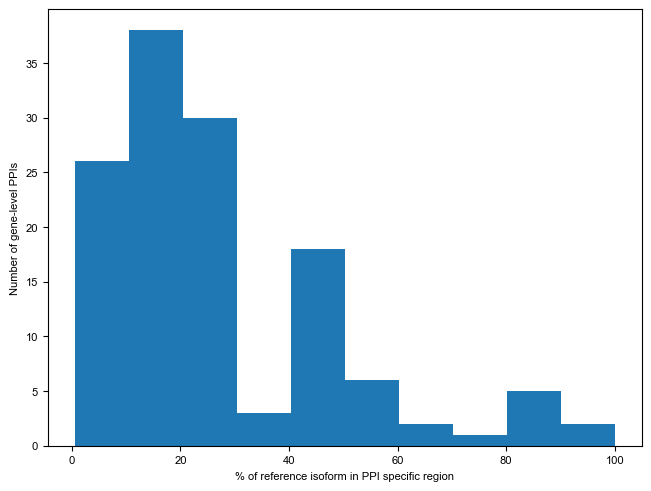

In [85]:
from matplotlib import pyplot as plt
(slim_ppis.loc[: ,['ad_gene_symbol', 'db_gene_symbol', 'isr_frac']].drop_duplicates()['isr_frac'] * 100).plot.hist()
plt.xlabel('% of reference isoform in PPI specific region')
plt.ylabel('Number of gene-level PPIs')
plt.savefig('../figures/fraction_isr.pdf', bbox_inches='tight')

In [86]:
slim_ppis_spec = slim_ppis.loc[slim_ppis['isr_frac'] <= 0.1, :].copy()
gg = slim_ppis_spec.loc[:, ['ad_gene_symbol', 'db_gene_symbol', 'aa_seq_ref_iso', 'isr_len']].drop_duplicates().copy().set_index(['ad_gene_symbol', 'db_gene_symbol'])

def rand_subseq(row):
    rand_start = np.random.randint((len(row['aa_seq_ref_iso']) - row['isr_len']) + 1)
    return row['aa_seq_ref_iso'][rand_start:rand_start + row['isr_len']]

null_dist = []
n_samples = 100
for __ in range(n_samples):
    rand_seq = gg.apply(rand_subseq, axis=1)
    rand_seq = pd.merge(rand_seq.rename('rand_aa_seq').reset_index(),
                        slim_ppis_spec.loc[:, ['ad_gene_symbol', 'db_gene_symbol', 'regex']],
                        how='inner')
    rand_seq['match_count_rand_aa_seq'] = rand_seq.apply(lambda x: len(re.findall(x['regex'], x['rand_aa_seq'])),
                    axis=1)
    null_dist.append((rand_seq.groupby(['ad_gene_symbol', 'db_gene_symbol'])['match_count_rand_aa_seq'].sum() > 0).sum())
real = (slim_ppis_spec.groupby(['ad_gene_symbol', 'db_gene_symbol'])['match_count_isr'].sum() > 0).sum()
n = slim_ppis_spec[['ad_gene_symbol', 'db_gene_symbol']].drop_duplicates().shape[0]
print('real = ', real, 'out of', n)
print('P =', len([n for n in null_dist if n >= real]) / n_samples)

real =  1 out of 26
P = 0.98


In [87]:
print(slim_ppis['match_count_ref_iso'].sum())
print(slim_ppis['match_count_isr'].sum())
print(slim_ppis['match_count_ref_iso'].sum() / slim_ppis['aa_seq_len_ref_iso'].sum())
print(slim_ppis['match_count_isr'].sum() / slim_ppis['isr_len'].sum())

1264
409
0.002244385927842282
0.0024791935650076073


In [88]:
res = slim_ppis.sort_values('motif_probability', ascending=True).drop_duplicates(['ad_gene_symbol', 'db_gene_symbol', 'pfam_accession'])
print(res['match_count_ref_iso'].sum() / res['aa_seq_len_ref_iso'].sum())
print(res['match_count_isr'].sum() / res['isr_len'].sum())
print((res['match_count_ref_iso'] - res['match_count_isr']).sum() / (res['aa_seq_len_ref_iso'] - res['isr_len']).sum())
print((slim_ppis.loc[slim_ppis['slim_match'],
               ['ad_gene_symbol', 'db_gene_symbol']]
          .drop_duplicates()
          .shape[0]))

0.00017859933471747817
0.00020874211998497057
0.00016759861654960158
37


In [89]:
slim_ppis.columns

Index(['ad_gene_symbol', 'db_gene_symbol', 'pfam_accession', 'domain_name',
       'domain_description', 'ELM identifier', 'aa_seq_isr', 'slim_match',
       'aa_seq_ref_iso', 'regex', 'match_count_ref_iso', 'match_count_isr',
       'aa_seq_len_ref_iso', 'isr_len', 'motif_probability', 'isr_frac'],
      dtype='object')

In [90]:
(slim_ppis.loc[slim_ppis['slim_match'], ['ad_gene_symbol', 'db_gene_symbol', 'domain_description', 'ELM identifier', 'regex', 'motif_probability']].sort_values('motif_probability')
.drop_duplicates(['ad_gene_symbol', 'db_gene_symbol', 'domain_description'])).to_csv('../output/slim_matches.csv', index=False)

In [91]:
match_pairs = (slim_ppis.loc[slim_ppis['slim_match'],
               ['ad_gene_symbol', 'db_gene_symbol']]
                .drop_duplicates())
match_pairs.head()

,ad_gene_symbol,db_gene_symbol
1501,TCF12,CDKN2C
2361,FOSB,NCK2
3312,STAT3,BLK
3597,PAX5,STAC
3631,MEIS2,HCK


In [92]:
print(match_pairs.shape[0], 'gene-level PPIs corresponding to motif in the isoform regions')
print('out of {} possible'.format(slim_ppis[['ad_gene_symbol', 'db_gene_symbol']].drop_duplicates().shape[0]))

37 gene-level PPIs corresponding to motif in the isoform regions
out of 131 possible


In [93]:
match_pairs['ad_gene_symbol'].value_counts().head()

MEOX1    5
TCF12    3
FOSB     3
STAT3    2
PAX5     2
Name: ad_gene_symbol, dtype: int64

In [94]:
slim_ppis.loc[slim_ppis['ad_gene_symbol'] == 'FOXP2', :]

,ad_gene_symbol,db_gene_symbol,pfam_accession,domain_name,domain_description,ELM identifier,aa_seq_isr,slim_match,aa_seq_ref_iso,regex,match_count_ref_iso,match_count_isr,aa_seq_len_ref_iso,isr_len,motif_probability,isr_frac


In [95]:
match_pairs['db_gene_symbol'].value_counts().head()

PIN1      4
MAPK9     3
EPHB6     2
PRKAA2    2
CDKN2C    1
Name: db_gene_symbol, dtype: int64

In [96]:
slim_ppis.loc[slim_ppis['slim_match'] & (slim_ppis['db_gene_symbol'] == 'PIN1'), :]

,ad_gene_symbol,db_gene_symbol,pfam_accession,domain_name,domain_description,ELM identifier,aa_seq_isr,slim_match,aa_seq_ref_iso,regex,match_count_ref_iso,match_count_isr,aa_seq_len_ref_iso,isr_len,motif_probability,isr_frac
21735,FOS,PIN1,PF00397,WW,WW domain,DOC_WW_Pin1_4,[MAAAKCRNRRRELTDTLQAETDQLEDEKSALQTEIANLLKEKEKLEFILAAHRPACKIPDDLGFPEEMSVASLDLTGGLPEVATPESEEAFTLPLLNDPEPKPSVEPVKSISSMELKTEPFDDFLFPASSRPSGSETARSVPDMDLSGSFYAADWEPLHSGSLGMGPMATELEPLCTPVVTCTPSCTAYTSSFVFTYPEADSFPSCAAAHRKGSSSNEPSSDSLSSPTLLAL],True,MMFSGFNADYEASSSRCSSASPAGDSLSYYHSPADSFSSMGSPVNAQDFCTDLAVSSANFIPTVTAISTSPDLQWLVQPALVSSVAPSQTRAPHPFGVPAPSAGAYSRAGVVKTMTGGRAQSIGRRGKVEQLSPEEEEKRRIRRERNKMAAAKCRNRRRELTDTLQAETDQLEDEKSALQTEIANLLKEKEKLEFILAAHRPACKIPDDLGFPEEMSVASLDLTGGLPEVATPESEEAFTLPLLNDPEPKP...,...(?:[ST])P.,9,4,380,232,0.015433,0.610526
21740,PBX1,PIN1,PF00397,WW,WW domain,DOC_WW_Pin1_4,[GSSSSFNMSNSGDLFMSVQSLNGDSYQGAQVGANVQSQVDTLRHVISQTGGYSDGLAASQMYSPQGISANGGWQDATTPSSVTSPTEGPGSVHSDTSN],True,MDEQPRLMHSHAGVGMAGHPSLSQHLQDGAGGTEGEGGRKQDIGDILQQIMTITDQSLDEAQARKHALNCHRMKPALFNVLCEIKEKTVLSIRGAQEEEPTDPQLMRLDNMLLAEGVAGPEKGGGSAAAAAAAAASGGAGSDNSVEHSDYRAKLSQIRQIYHTELEKYEQACNEFTTHVMNLLREQSRTRPISPKEIERMVSIIHRKFSSIQMQLKQSTCEAVMILRSRFLDARRKRRNFNKQATEILNEY...,...(?:[ST])P.,5,3,430,98,0.015433,0.227907
21742,FOXN4,PIN1,PF00397,WW,WW domain,DOC_WW_Pin1_4,[MIESDTSSIMSGIIRNSGQNHHPSPQEYRLLATTSDDDLPGDLQSLSWLTAVDVPRLQQMASGRVDLGGPCVPHPHPGALAGVADLHVGATPSPLLHGPAGMAPRGMPGLGPITGHRDSMSQFPVGGQPSSGLQDPPHLYSPATQPQFPLPPGAQQCPPVGLYGPPFGVRPPYPQPHVAVHSSQELHPKHYPKPIYSYS],True,MIESDTSSIMSGIIRNSGQNHHPSPQEYRLLATTSDDDLPGDLQSLSWLTAVDVPRLQQMASGRVDLGGPCVPHPHPGALAGVADLHVGATPSPLLHGPAGMAPRGMPGLGPITGHRDSMSQFPVGGQPSSGLQDPPHLYSPATQPQFPLPPGAQQCPPVGLYGPPFGVRPPYPQPHVAVHSSQELHPKHYPKPIYSYSCLIAMALKNSKTGSLPVSEIYSFMKEHFPYFKTAPDGWKNSVRHNLSLNKCF...,...(?:[ST])P.,9,3,517,199,0.015433,0.384913
21752,MEOX1,PIN1,PF00397,WW,WW domain,DOC_WW_Pin1_4,[MDPAASSCMRSLQPPAPVWGCLRNPHSEGNGASGLPHYPPTPFSFHQKPDFLATATAAYPDFSASCLAATPHSLPQEEHIFTEQHPAFPQSPNWHFPVSDARRRPNSGPAGGSKE],True,MDPAASSCMRSLQPPAPVWGCLRNPHSEGNGASGLPHYPPTPFSFHQKPDFLATATAAYPDFSASCLAATPHSLPQEEHIFTEQHPAFPQSPNWHFPVSDARRRPNSGPAGGSKEMGTSSLGLVDTTGGPGDDYGVLGSTANETEKKSSRRRKESSDNQENRGKPEGSSKARKERTAFTKEQLRELEAEFAHHNYPTRLRRYEIAVNLDLSERQVKVWFQNRRMKWKRVKGGQPISPNGQDPEDGDSTASPSSE,...(?:[ST])P.,5,3,254,115,0.015433,0.452756


Pin1 Links the Activities of c-Abl
and p300 in Regulating p73 Function, Mol. Cell, 2004

It has been showing that TP73 isoforms lacking the PIN1 interacting motif have reduced transcriptional activity.

Also the mouse FOS has the PIN1 motif binding shown.

In [97]:
ppi.loc[ppi['db_gene_symbol'] == 'PIN1',
        'ad_gene_symbol'].nunique()
ppi.loc[ppi['db_gene_symbol'] == 'PIN1',
        'ad_gene_symbol'].unique()

array(['GLI1', 'TP63', 'FOXP2', 'ZNF212', 'ETV6', 'FOS', 'ZBTB7B', 'PBX1',
       'FOXN4', 'TCF4', 'MEOX1', 'TCF12', 'RELA'], dtype=object)

In [98]:
# smallest region
slim_ppis['isr_length'] = slim_ppis['aa_seq_isr'].apply(lambda x: min(len(s) for s in x))
(slim_ppis.loc[slim_ppis['slim_match'], :]
          .sort_values('isr_length')
          .drop_duplicates(['ad_gene_symbol', 'db_gene_symbol', 'pfam_accession'])
          .head(30))

/var/folders/4f/st3pbvs10sd68jl3b4p861h80000gn/T/ipykernel_72223/2315733334.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  slim_ppis['isr_length'] = slim_ppis['aa_seq_isr'].apply(lambda x: min(len(s) for s in x))


,ad_gene_symbol,db_gene_symbol,pfam_accession,domain_name,domain_description,ELM identifier,aa_seq_isr,slim_match,aa_seq_ref_iso,regex,match_count_ref_iso,match_count_isr,aa_seq_len_ref_iso,isr_len,motif_probability,isr_frac,isr_length
1501,TCF12,CDKN2C,PF00023,Ank,Ankyrin repeat,DOC_ANK_TNKS_1,"[MNPQQQRMAAIGTDKELSDLLDFSAMFSPPVNSGKTRPTTLGSSQFSGSGIDERGGTTSWGTSGQPSPSYDSSRGFTDSPHYSDHLNDSRLGAHEGLSPTPFMNSNLMGKTSERGSFSLYSRDTGLPGCQSSLLRQDLGLGSPAQLSSSGKPGTAYYSFSATSSRRRPLHDSAALDPLQAKKVRKVPPGLPSS, Q]",True,MNPQQQRMAAIGTDKELSDLLDFSAMFSPPVNSGKTRPTTLGSSQFSGSGIDERGGTTSWGTSGQPSPSYDSSRGFTDSPHYSDHLNDSRLGAHEGLSPTPFMNSNLMGKTSERGSFSLYSRDTGLPGCQSSLLRQDLGLGSPAQLSSSGKPGTAYYSFSATSSRRRPLHDSAALDPLQAKKVRKVPPGLPSSVYAPSPNSDDFNRESPSYPSPKPPTSMFASTFFMQDGTHNSSDLWSSSNGMSQPGFGG...,.R..[PGAV][DEIP]G.,2,2,706,194,0.000354,0.274788,1
14541,TCF12,NEK6,PF00069,Pkinase,Protein kinase domain,MOD_CK1_1,"[MNPQQQRMAAIGTDKELSDLLDFSAMFSPPVNSGKTRPTTLGSSQFSGSGIDERGGTTSWGTSGQPSPSYDSSRGFTDSPHYSDHLNDSRLGAHEGLSPTPFMNSNLMGKTSERGSFSLYSRDTGLPGCQSSLLRQDLGLGSPAQLSSSGKPGTAYYSFSATSSRRRPLHDSAALDPLQAKKVRKVPPGLPSS, Q]",True,MNPQQQRMAAIGTDKELSDLLDFSAMFSPPVNSGKTRPTTLGSSQFSGSGIDERGGTTSWGTSGQPSPSYDSSRGFTDSPHYSDHLNDSRLGAHEGLSPTPFMNSNLMGKTSERGSFSLYSRDTGLPGCQSSLLRQDLGLGSPAQLSSSGKPGTAYYSFSATSSRRRPLHDSAALDPLQAKKVRKVPPGLPSSVYAPSPNSDDFNRESPSYPSPKPPTSMFASTFFMQDGTHNSSDLWSSSNGMSQPGFGG...,S..(?:[ST])...,21,6,706,194,0.017041,0.274788,1
3793,MEIS2,HCK,PF00017,SH2,SH2 domain,LIG_SH2_NCK_1,"[MAQRYDELPHYGG, GLQSMPGDYVSQGGPMGMSMAQPSYTPPQMTPHPTQLRHGPPMHSYLPSHPHHPAMMMHGGPPTHPGMTMSAQSPTMLNSVDPNVGGQVMDIHAQ]",True,MAQRYDELPHYGGMDGVGVPASMYGDPHAPRPIPPVHHLNHGPPLHATQHYGAHAPHPNVMPASMGSAVNDALKRDKDAIYGHPLFPLLALVFEKCELATCTPREPGVAGGDVCSSDSFNEDIAVFAKQVRAEKPLFSSNPELDNLMIQAIQVLRFHLLELEKVHELCDNFCHRYISCLKGKMPIDLVIDERDGSSKSDHEELSGSSTNLADHNPSSWRDHDDATSTHSAGTPGPSSGGHASQSGDNSSEQ...,(?:Y)[DESTNA][^GWFY][VPAI][DENQSTAGYFP],1,1,477,108,0.000829,0.226415,13
3742,MEIS2,HCK,PF00069,Pkinase,Protein kinase domain,MOD_Plk_4,"[MAQRYDELPHYGG, GLQSMPGDYVSQGGPMGMSMAQPSYTPPQMTPHPTQLRHGPPMHSYLPSHPHHPAMMMHGGPPTHPGMTMSAQSPTMLNSVDPNVGGQVMDIHAQ]",True,MAQRYDELPHYGGMDGVGVPASMYGDPHAPRPIPPVHHLNHGPPLHATQHYGAHAPHPNVMPASMGSAVNDALKRDKDAIYGHPLFPLLALVFEKCELATCTPREPGVAGGDVCSSDSFNEDIAVFAKQVRAEKPLFSSNPELDNLMIQAIQVLRFHLLELEKVHELCDNFCHRYISCLKGKMPIDLVIDERDGSSKSDHEELSGSSTNLADHNPSSWRDHDDATSTHSAGTPGPSSGGHASQSGDNSSEQ...,..[^IRFW](?:[ST])[ILMVFWY][ILMVFWY].,5,2,477,108,0.006019,0.226415,13
3631,MEIS2,HCK,PF00018,SH3_1,SH3 domain,LIG_SH3_3,"[MAQRYDELPHYGG, GLQSMPGDYVSQGGPMGMSMAQPSYTPPQMTPHPTQLRHGPPMHSYLPSHPHHPAMMMHGGPPTHPGMTMSAQSPTMLNSVDPNVGGQVMDIHAQ]",True,MAQRYDELPHYGGMDGVGVPASMYGDPHAPRPIPPVHHLNHGPPLHATQHYGAHAPHPNVMPASMGSAVNDALKRDKDAIYGHPLFPLLALVFEKCELATCTPREPGVAGGDVCSSDSFNEDIAVFAKQVRAEKPLFSSNPELDNLMIQAIQVLRFHLLELEKVHELCDNFCHRYISCLKGKMPIDLVIDERDGSSKSDHEELSGSSTNLADHNPSSWRDHDDATSTHSAGTPGPSSGGHASQSGDNSSEQ...,...[PV]..P,7,2,477,108,0.013173,0.226415,13
12797,TCF12,EPHB6,PF00069,Pkinase,Protein kinase domain,MOD_Plk_4,[KNRVEQQLHEHLQDAMSFLKDVCE],True,MNPQQQRMAAIGTDKELSDLLDFSAMFSPPVNSGKTRPTTLGSSQFSGSGIDERGGTTSWGTSGQPSPSYDSSRGFTDSPHYSDHLNDSRLGAHEGLSPTPFMNSNLMGKTSERGSFSLYSRDTGLPGCQSSLLRQDLGLGSPAQLSSSGKPGTAYYSFSATSSRRRPLHDSAALDPLQAKKVRKVPPGLPSSVYAPSPNSDDFNRESPSYPSPKPPTSMFASTFFMQDGTHNSSDLWSSSNGMSQPGFGG...,..[^IRFW](?:[ST])[ILMVFWY][ILMVFWY].,11,1,706,24,0.006019,0.033994,24
14489,HMBOX1,CDK18,PF00069,Pkinase,Protein kinase domain,MOD_Plk_1,[DDSTSHSDHQDPISLAVEMAAVNHTILALARQGANEIKTEALDDD],True,MLSSFPVVLLETMSHYTDEPRFTIEQIDLLQRLRRTGMTKHEILHALETLDRLDQEHSDKFGRRSSYGGSSYGNSTNNVPASSSTATASTQTQHSGMSPSPSNSYDTSPQPCTTNQNGRENNERLSTSNGKMSPTRYHANSMGQRSYSFEASEEDLDVDDKVEELMRRDSSVIKEEIKAFLANRRISQAVVAQVTGISQSRISHWLLQQGSDLSEQKKRAFYRWYQLEKTNPGATLSMRPAPIPIEDPEWR...,.[DNE][^PG][ST](?:(?:[FYILMVW]..)|(?:[^PEDGKN][FWYLIVM]).),2,1,420,45,0.007674,0.107143,45
22158,HMBOX1,UBE2Z,PF00179,UQ_con,Ubiquitin-conjugating enzyme,MOD_SUMO_for_1,[DDSTSHSDHQDPISLAVEMAAVNHTILALARQGANEIKTEALDDD],True,MLSSFPVVLLETMSHYTDEPRFTIEQIDLLQRLRRTGMTKHEILHALETLDRLDQEHSDKFGRRSSYGGSSYGNSTNNVPASSSTATASTQTQHSGMSPSPSNSYDTSPQPCTTNQNGREN

In [99]:
# most specific regex
(slim_ppis.loc[slim_ppis['slim_match'], :]
          .sort_values('motif_probability')
          .drop_duplicates(['ad_gene_symbol', 'db_gene_symbol', 'pfam_accession'])
          .head(30))

,ad_gene_symbol,db_gene_symbol,pfam_accession,domain_name,domain_description,ELM identifier,aa_seq_isr,slim_match,aa_seq_ref_iso,regex,match_count_ref_iso,match_count_isr,aa_seq_len_ref_iso,isr_len,motif_probability,isr_frac,isr_length
20889,CREBZF,HCFC1,PF13415,Kelch_3,"Galactose oxidase, central domain",LIG_HCF-1_HBM_1,[MRHSLTKLLAASGSNSPTRSESPEPAATCSLPSDLTRAAAGEEETAAAGSPGRKQQFGDEGELEAGRGSRGGVAVRAPSPEEMEEEAIASLPGEETEDMDFLSGLELADLLDPRQPDWHLDPGLSSPGPLSSSGGGSDSGGLWRGDDDDEAAAAEMQRFSDLLQRLLNGIGGCSSSSDSGSAEKRRRKSPGGGGGGGSGNDNNQAATKSPRKAAAAAARLNRLKKKEYVMGLESRVRGLAAENQELRAEN...,True,MRHSLTKLLAASGSNSPTRSESPEPAATCSLPSDLTRAAAGEEETAAAGSPGRKQQFGDEGELEAGRGSRGGVAVRAPSPEEMEEEAIASLPGEETEDMDFLSGLELADLLDPRQPDWHLDPGLSSPGPLSSSGGGSDSGGLWRGDDDDEAAAAEMQRFSDLLQRLLNGIGGCSSSSDSGSAEKRRRKSPGGGGGGGSGNDNNQAATKSPRKAAAAAARLNRLKKKEYVMGLESRVRGLAAENQELRAENR...,[DE]H.Y,1,1,354,354,0.000051,1.000000,354
22286,NFIX,MLH1,PF16413,Mlh1_C,DNA mismatch repair protein Mlh1 C-terminus,LIG_MLH1_MIPbox_1,[GSPRATASALHFPSTSIIQQSSPYFTHPTIRYHHHHGQDSLKEFVQFVCSDGSGQATGQHSQRQAPPLPTGLSASDPGTATF],True,MYSPYCLTQDEFHPFIEALLPHVRAFSYTWFNLQARKRKYFKKHEKRMSKDEERAVKDELLGEKPEIKQKWASRLLAKLRKDIRPEFREDFVLTITGKKPPCCVLSNPDQKGKIRRIDCLRQADKVWRLDLVMVILFKGIPLESTDGERLYKSPQCSNPGLCVQPHHIGVTIKELDLYLAYFVHTPESGQSDSSNQQGDADIKPLPNGHLSFQDCFVTSGVWNVTELVRVSQTPVATASGPNFSLADLESP...,.S.[FY][F],1,1,441,82,0.000062,0.185941,82
18133,ZNF263,CLK2,PF00069,Pkinase,Protein kinase domain,DOC_MAPK_HePTP_8,[VTNHGRGTEVLLEEPLPLETARESPSFKLEPMETERSPGPRLQELLGPSPQRDPQAVKERALSAPWLSLFPPEGNMEDKEMTGPQLPESLEDVAMYISQEEWGHQDPSKRALSRDTVQESYENVDSLESHIPSQEVPGTQVGQGGKLWDPSVQSCKEGLSPRGPAPGEEKFENLEGVPSVCSENIHPQVLLPDQARGEVPWSPELGRPHDRSQGDWAPPPEGGMEQALAGASSGRELGRPKELQPKKLHL...,True,MASGPGSQEREGLLIVKLEEDCAWSQELPPPDPGPSPEASHLRFRRFRFQEAAGPREALSRLQELCHGWLRPEMRTKEQILELLVLEQFLTILPQEIQSRVQELHPESGEEAVTLVEDMQRELGRLRQQVTNHGRGTEVLLEEPLPLETARESPSFKLEPMETERSPGPRLQELLGPSPQRDPQAVKERALSAPWLSLFPPEGNMEDKEMTGPQLPESLEDVAMYISQEEWGHQDPSKRALSRDTVQESYE...,"(?:[LIV][^P][^P][RK]....[LIVMP].[LIV].[LIVMF])|(?:[LIV][^P][^P][RK][RK]G.{4,7}[LIVMP].[LIV].[LIVMF])",1,1,683,554,0.000107,0.811127,554
15463,ZNF263,CLK3,PF00069,Pkinase,Protein kinase domain,DOC_MAPK_HePTP_8,[VTNHGRGTEVLLEEPLPLETARESPSFKLEPMETERSPGPRLQELLGPSPQRDPQAVKERALSAPWLSLFPPEGNMEDKEMTGPQLPESLEDVAMYISQEEWGHQDPSKRALSRDTVQESYENVDSLESHIPSQEVPGTQVGQGGKLWDPSVQSCKEGLSPRGPAPGEEKFENLEGVPSVCSENIHPQVLLPDQARGEVPWSPELGRPHDRSQGDWAPPPEGGMEQALAGASSGRELGRPKELQPKKLHL...,True,MASGPGSQEREGLLIVKLEEDCAWSQELPPPDPGPSPEASHLRFRRFRFQEAAGPREALSRLQELCHGWLRPEMRTKEQILELLVLEQFLTILPQEIQSRVQELHPESGEEAVTLVEDMQRELGRLRQQVTNHGRGTEVLLEEPLPLETARESPSFKLEPMETERSPGPRLQELLGPSPQRDPQAVKERALSAPWLSLFPPEGNMEDKEMTGPQLPESLEDVAMYISQEEWGHQDPSKRALSRDTVQESYE...,"(?:[LIV][^P][^P][RK]....[LIVMP].[LIV].[LIVMF])|(?:[LIV][^P][^P][RK][RK]G.{4,7}[LIVMP].[LIV].[LIVMF])",1,1,683,554,0.000107,0.811127,554
22341,SOX5,CTBP2,PF00389,2-Hacid_dh,"D-isomer specific 2-hydroxyacid dehydrogenase, catalytic domain",LIG_CtBP_PxDLS_1,[MSVMSSKRPASPYGEADGEVAMVTSRQKVEEEESDGLPAFHLPLHVSFPNKPHSEEFQPVSLLTQETCGHRTPTSQHNTMEVDGNKVMSSFAPHNSSTSPQKAEEGGRQSGESLSSTALGTPERRKGSLADVVDTLKQRKMEELIKNEPEETPSIEKLLSKDWKDKLLAMGSGNFGEIKGTPESLAEKERQLMGMINQLTSLREQLLAAHDEQKKLAASQIEKQRQQMELAKQQQEQIARQQQQLLQQQH...,True,MSVMSSKRPASPYGEADGEVAMVTSRQKVEEEESDGLPAFHLPLHVSFPNKPHSEEFQPVSLLTQETCGHRTPTSQHNTMEVDGNKVMSSFAPHNSSTSPQKAEEGGRQSGESLSSTALGTPERRKGSLADVVDTLKQRKMEELIKNEPEETPSIEKLLSKDWKDKLLAMGSGNFGEIKGTPESLAEKERQLMGMINQLTSLREQLLAAHDEQKKLAASQIEKQRQQMELAKQQQEQIARQQQQLLQQQHK...,(?:P[LVIPME][DENS][LM][VASTRG])|(?:G[LVIPME][DENS][LM][VASTRG](?:(?:K)|(?:.[KR]))),2,1,753,378,0.000117,0.501992,378
22016,FOSB,HOMER3,PF00568,WH1,WH1 domain,LIG_EVH1_1,[VRDLPGSAPAKEDGFSWLLPPPPPPPLPFQTSQDAPPNLTASLFTHSEVQVLGDPFPVVNPSYTSSFVLTCPEVSAFAGAQRTSGSDQPSDPLNSPSLLAL],True,MFQAFPGDYDSGSRCSSSPSAESQYLSSVDSFGSPPTAAASQECAGLGEMPGSFVPTVTAITTSQDLQWLVQPTLISSMAQSQGQPLASQPPVVDPYDMPGTSYSTPGMSGYSSGGASGSGGPSTSGTTSGPGPARPARARPRRPREETLTPEEEEKRRVRRERNKLAAAKCRNRRRELTDRLQAETDQLEEEKAELESEIAELQKEKERLEFVLVAHKPGCKIPYEEGPGPGPLAEVRDLPGSAPAKEDG...,(?:[FYWL]P.PP)|(?:[FYW

In [100]:
slim_ppis.loc[slim_ppis['slim_match'] & (slim_ppis['ad_gene_symbol'] == 'STAT3'), :]

,ad_gene_symbol,db_gene_symbol,pfam_accession,domain_name,domain_description,ELM identifier,aa_seq_isr,slim_match,aa_seq_ref_iso,regex,match_count_ref_iso,match_count_isr,aa_seq_len_ref_iso,isr_len,motif_probability,isr_frac,isr_length
3312,STAT3,BLK,PF00069,Pkinase,Protein kinase domain,MOD_CK1_1,[MAQWNQLQQLDTRYLEQLHQLYSDSFPMELRQFLAPWIESQDWAYAASKESHATLVFHNLLGEIDQQYSRFLQESNVLYQHNLRRIKQFLQSRYLEKP],True,MAQWNQLQQLDTRYLEQLHQLYSDSFPMELRQFLAPWIESQDWAYAASKESHATLVFHNLLGEIDQQYSRFLQESNVLYQHNLRRIKQFLQSRYLEKPMEIARIVARCLWEESRLLQTAATAAQQGGQANHPTAAVVTEKQQMLEQHLQDVRKRVQDLEQKMKVVENLQDDFDFNYKTLKSQGDMQDLNGNNQSVTRQKMQQLEQMLTALDQMRRSIVSELAGLLSAMEYVQKTLTDEELADWKRRQQIAC...,S..(?:[ST])...,6,1,769,98,0.017041,0.127438,98
3357,STAT3,BLK,PF00069,Pkinase,Protein kinase domain,MOD_NEK2_1,[MAQWNQLQQLDTRYLEQLHQLYSDSFPMELRQFLAPWIESQDWAYAASKESHATLVFHNLLGEIDQQYSRFLQESNVLYQHNLRRIKQFLQSRYLEKP],True,MAQWNQLQQLDTRYLEQLHQLYSDSFPMELRQFLAPWIESQDWAYAASKESHATLVFHNLLGEIDQQYSRFLQESNVLYQHNLRRIKQFLQSRYLEKPMEIARIVARCLWEESRLLQTAATAAQQGGQANHPTAAVVTEKQQMLEQHLQDVRKRVQDLEQKMKVVENLQDDFDFNYKTLKSQGDMQDLNGNNQSVTRQKMQQLEQMLTALDQMRRSIVSELAGLLSAMEYVQKTLTDEELADWKRRQQIAC...,[FLM][^P][^P](?:[ST])[^DEP][^DE],11,2,769,98,0.009798,0.127438,98
3399,STAT3,BLK,PF00069,Pkinase,Protein kinase domain,MOD_Plk_4,[MAQWNQLQQLDTRYLEQLHQLYSDSFPMELRQFLAPWIESQDWAYAASKESHATLVFHNLLGEIDQQYSRFLQESNVLYQHNLRRIKQFLQSRYLEKP],True,MAQWNQLQQLDTRYLEQLHQLYSDSFPMELRQFLAPWIESQDWAYAASKESHATLVFHNLLGEIDQQYSRFLQESNVLYQHNLRRIKQFLQSRYLEKPMEIARIVARCLWEESRLLQTAATAAQQGGQANHPTAAVVTEKQQMLEQHLQDVRKRVQDLEQKMKVVENLQDDFDFNYKTLKSQGDMQDLNGNNQSVTRQKMQQLEQMLTALDQMRRSIVSELAGLLSAMEYVQKTLTDEELADWKRRQQIAC...,..[^IRFW](?:[ST])[ILMVFWY][ILMVFWY].,5,1,769,98,0.006019,0.127438,98
3423,STAT3,BLK,PF00017,SH2,SH2 domain,LIG_SH2_STAT3,[MAQWNQLQQLDTRYLEQLHQLYSDSFPMELRQFLAPWIESQDWAYAASKESHATLVFHNLLGEIDQQYSRFLQESNVLYQHNLRRIKQFLQSRYLEKP],True,MAQWNQLQQLDTRYLEQLHQLYSDSFPMELRQFLAPWIESQDWAYAASKESHATLVFHNLLGEIDQQYSRFLQESNVLYQHNLRRIKQFLQSRYLEKPMEIARIVARCLWEESRLLQTAATAAQQGGQANHPTAAVVTEKQQMLEQHLQDVRKRVQDLEQKMKVVENLQDDFDFNYKTLKSQGDMQDLNGNNQSVTRQKMQQLEQMLTALDQMRRSIVSELAGLLSAMEYVQKTLTDEELADWKRRQQIAC...,(?:Y)..Q,2,1,769,98,0.000797,0.127438,98
3426,STAT3,BLK,PF00017,SH2,SH2 domain,LIG_SH2_STAT5,[MAQWNQLQQLDTRYLEQLHQLYSDSFPMELRQFLAPWIESQDWAYAASKESHATLVFHNLLGEIDQQYSRFLQESNVLYQHNLRRIKQFLQSRYLEKP],True,MAQWNQLQQLDTRYLEQLHQLYSDSFPMELRQFLAPWIESQDWAYAASKESHATLVFHNLLGEIDQQYSRFLQESNVLYQHNLRRIKQFLQSRYLEKPMEIARIVARCLWEESRLLQTAATAAQQGGQANHPTAAVVTEKQQMLEQHLQDVRKRVQDLEQKMKVVENLQDDFDFNYKTLKSQGDMQDLNGNNQSVTRQKMQQLEQMLTALDQMRRSIVSELAGLLSAMEYVQKTLTDEELADWKRRQQIAC...,(?:Y)[VLTFIC]..,9,2,769,98,0.003296,0.127438,98
3447,STAT3,BLK,PF00017,SH2,SH2 domain,LIG_SH2_STAP1,[MAQWNQLQQLDTRYLEQLHQLYSDSFPMELRQFLAPWIESQDWAYAASKESHATLVFHNLLGEIDQQYSRFLQESNVLYQHNLRRIKQFLQSRYLEKP],True,MAQWNQLQQLDTRYLEQLHQLYSDSFPMELRQFLAPWIESQDWAYAASKESHATLVFHNLLGEIDQQYSRFLQESNVLYQHNLRRIKQFLQSRYLEKPMEIARIVARCLWEESRLLQTAATAAQQGGQANHPTAAVVTEKQQMLEQHLQDVRKRVQDLEQKMKVVENLQDDFDFNYKTLKSQGDMQDLNGNNQSVTRQKMQQLEQMLTALDQMRRSIVSELAGLLSAMEYVQKTLTDEELADWKRRQQIAC...,(?:Y)[DESTA][^GP][^GP][ILVFMWYA],2,2,769,98,0.001026,0.127438,98
3995,STAT3,TXK,PF00069,Pkinase,Protein kinase domain,MOD_CK1_1,[MAQWNQLQQLDTRYLEQLHQLYSDSFPMELRQFLAPWIESQDWAYAASKESHATLVFHNLLGEIDQQYSRFLQESNVLYQHNLRRIKQFLQSRYLEKP],True,MAQWNQLQQLDTRYLEQLHQLYSDSFPMELRQFLAPWIESQDWAYAASKESHATLVFHNLLGEIDQQYSRFLQESNVLYQHNLRRIKQFLQSRYLEKPMEIARIVARCLWEESRLLQTAATAAQQGGQANHPTAAVVTEKQQMLEQHLQDVRKRVQDLEQKMKVVENLQDDFDFNYKTLKSQGDMQDLNGNNQSVTRQKMQQLEQMLTALDQMRRSIVSELAGLLSAMEYVQKTLTDEELADWKRRQQIAC...,S..(?:[ST])...,6,1,769,98,0.017041,0.127438,98
4175,STAT3,TXK,PF00069,Pkinase,Protein kinase domain,MOD_NEK2_1,[MAQWNQLQQLDTRYLEQLHQLYSDSFPMELRQFLAPWIESQDWAYAASKESHATLVFHNLLGEIDQQYSRFLQESNVLYQHNLRRIKQFLQSRYLEKP],True,MAQWNQLQQLDTRYLEQLHQLYSDSFPMELRQFLAPWIESQDWAYAASKESHATLVFHNLLGEIDQQYSRFLQESNVLYQHNLRRIKQFLQSRYLEKPMEIARIVARCLWEESRLLQTAATAAQQGGQANHPTAAVVTEKQQMLEQHLQDVRKRVQDLEQKMKVVENLQDDFDFNYKTLKSQGDMQDLNGNNQSVTRQKMQQLEQMLTALDQMRRSIVSELAGLLSAMEYVQKTLTDEELADWKRRQQIAC...,[FLM][^P][^P](?:[ST]